In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

#Scipy is a library used for scientific and technical computing,it provides functions for interpolation,linear algebra etc.
from scipy import stats 

#Used to handle apearance of date and time data on plots
import  matplotlib.dates as mdates

from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff    #Used for creating visualizations like heatmaps,histograpms etc.
import plotly.graph_objs as go    #Used for creating interactive plots such as scatter plots,bar chart etc.

#This initialized plotly usage within jupyter notebook,2nd fucntion is used to save plotly plot as HTML files so they can be
#viewed in web browsers,3rd fucntion is used to display plotly plots directly in jupyter notebook
from plotly.offline import init_notebook_mode, plot, iplot    

#It is used for estimating and analyzing various statistical models,it includes tools for regression,timeseries analysis etc
import statsmodels.api as sm

#This function is used to decompose time series into its trends,seasonal and residual components.
from statsmodels.tsa.seasonal import seasonal_decompose

#This function is used for performing the Augmented Dickey-Fuller test, used to check stationarity of a time series.
#Stationarity in terms of time series refers to a property where statistical properties such as mean, variance and autocorr-
#elation remain constant over time. In other words a  stationary time series exhibits constant behaviour over time, making
#it easier to predict future values.
from statsmodels.tsa.stattools import adfuller

#This function is used to evaluate the performance of regression models by measuring average square differences of actual 
#values and predicted values
from sklearn.metrics import mean_squared_error

#Importing the ARIMA class for fitting and forecasting time series data using ARIMA models, which are powerful for tsa
from statsmodels.tsa.arima.model import ARIMA

#Thes functions are used to plot auto correlation fucntion and partial auto correlation fucntion of a time series. They are
#used to find out how closely realted today's observation and a observations of a few days ago are. ACF is used for comparision
#with observations of a few days ago and PACF is used for comparision with yesterday's observation(or the closest before today)  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#This sets up the environment for working with plotly and matplotlib in jupyter notebook.
init_notebook_mode(connected=True)
#%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
#Customize the appearance of plots
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [24]:
import mplfinance as mpf    #Used for financial data plotting
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [25]:
#Read the dataframe
df = pd.read_csv('Stock Prices/all_stocks_5yr.csv')

#df.head() displays the first few rows of the dataframe
df.head().style.set_properties(**{  'color': 'red',
                                    'border': '1.5px  white'})

In [26]:
#Defining simple fucntions to get all the information needed
def information_function(df):
    
    #df[name] selects the name column and then calculates all the unique entries in it thus returning total no. of stocks
    print("Unique Stocks available in dataset: ",df['Name'].nunique())
    print("----"*20)
    
    #metadata of dataset such as column data type, memory usage etc
    print("Metadata of the dataset: ")
    df.info()
    print("----"*20)
    
    #is_null will create an corresponding dataframe where all the missing values or nan values are marked as true and others
    #as false, then sum() will return the sum of all true values(1) along each column as a series
    null = df.isnull().sum()
    print(null)
    print("----"*20)
    
    #Time range of this dataset
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stock dataset is: ",delta)
    print("----"*20)

In [27]:
information_function(df)

Unique Stocks available in dataset:  505
--------------------------------------------------------------------------------
Metadata of the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
--------------------------------------------------------------------------------
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
--------------------------------------------------------------------------------
Time range of stock dataset is:  1825 days 00:00:00
-------------------

<h1 style="background-color:red;color:yellow; padding:10px;">DATA CLEANING</h1>

In [28]:
#Rename name to ticks , orignal dataframe's name isn't changed a new one with modified name is created and assigned to rdf
rdf = df.rename(columns={'Name':'ticks'})

#Droping all the rows with null values , as they are very few to begin with
rdf.dropna(inplace=True)

#Changing the datatype of date column
new_df = rdf.copy()

#Using the loc accessor to access new_df : indicates that all rows are selcted and date means that date column has been
#selcted, the pd.to_datetime func converts all the values in date column to date time format 
new_df['date'] = pd.to_datetime(rdf['date'])

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


# <h1 style="background-color:red;color:yellow; padding:10px;">TOP 10 STOCKS BY AVERAGE TRADING</h1>

In [29]:
mean_dict = {}

#Key will be all the unique names in the ticks column one by one each iteration,then new_df[ticks]==key will check which 
#entries in tick column are equal to key and return a true false boolean mask corresponding to it. when a boolean mask is 
#passed to a dataframe then only the rows whose corresponding value is true in the boolean mask are selected.This way we can 
#get a dataframe with only the 'key' entries and then calculate the mean value of its volume.
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks']==key]['volume'].mean()
    mean_dict[key] = value

print("Length of the mean of ticks dictionary:", len(mean_dict))

#This will convert the dictionary into a series of elements like AAPL:100, MSFT:2000,... transpose is used to switch rows
#and columns but is no necessary here.
average_s = pd.Series(mean_dict).transpose()

#Sorting them in decending order and keeping only the top 10 values to get the most traded stocks
top10_s = average_s.sort_values(ascending=False)[:10]

print("Top 10 companies with highes traded stocks: \n",top10_s.index)

Length of the mean of ticks dictionary: 505
Top 10 companies with highes traded stocks: 
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [30]:
#Function to get particular top 10 Company's dataframe from the orignal dataframe

def subdataframe(df,tick):
    ticks = list(top10_s.index)
    
    
    #This will check wether tick is present in the ticks list or not and if its not present it will display the following 
    #error and the lines below the aassert statement will not be executed
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    #This will again pass an boolean filter to the dataframe of only the rows where the tick is present and then we will get
    #all the rows of that particular tick
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [31]:
#Creating a Dictionary for top 10 stock company names and their ticks
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

#Creating subdatarfames for all companies
bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')

# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    #df = df.style.format('{:.2f}%', subset='daily return')
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")


		Start Date					End Date
BAC		2013-02-08 00:00:00			2018-02-07 00:00:00
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
GE		2013-02-08 00:00:00			2018-02-07 00:00:00
F		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
MSFT		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
MU		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00
CSCO		2013-02-08 00:00:00			2018-02-07 00:00:00


# <h1 style="background-color:red;color:yellow; padding:10px;">CLOSING STOCK PRICE VISUALIZATIONS & MAXIMUM PRICE DURING 5 YEARS</h1>

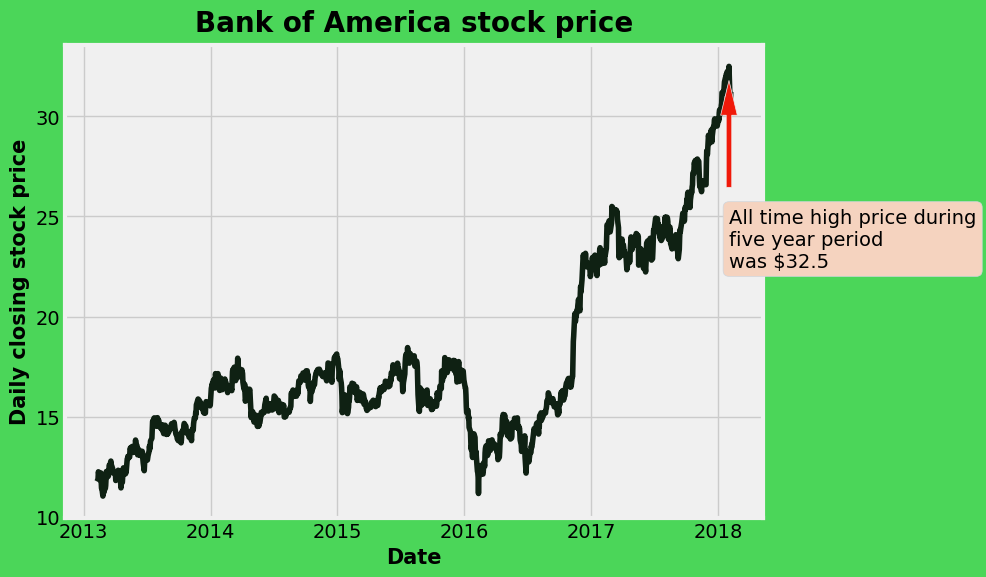

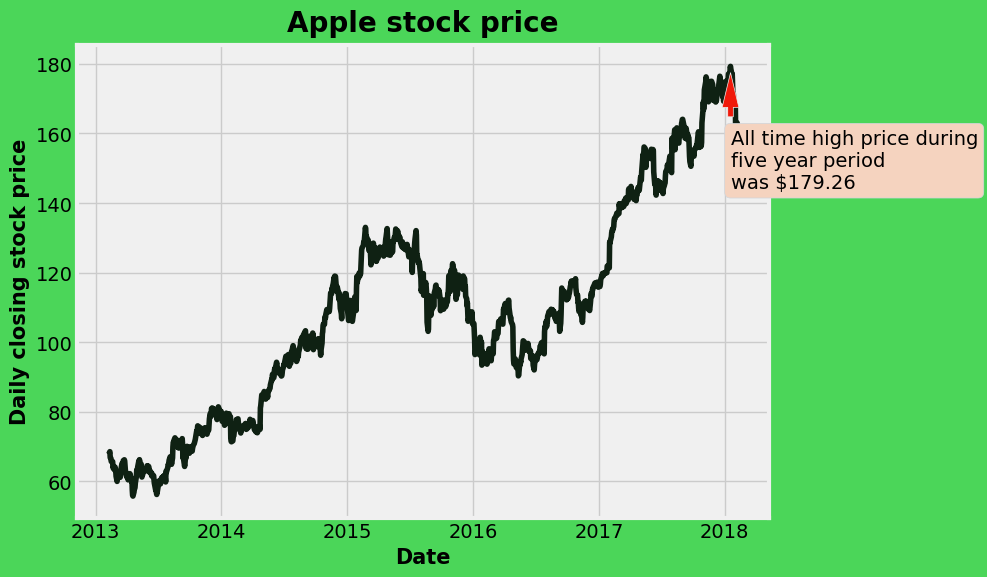

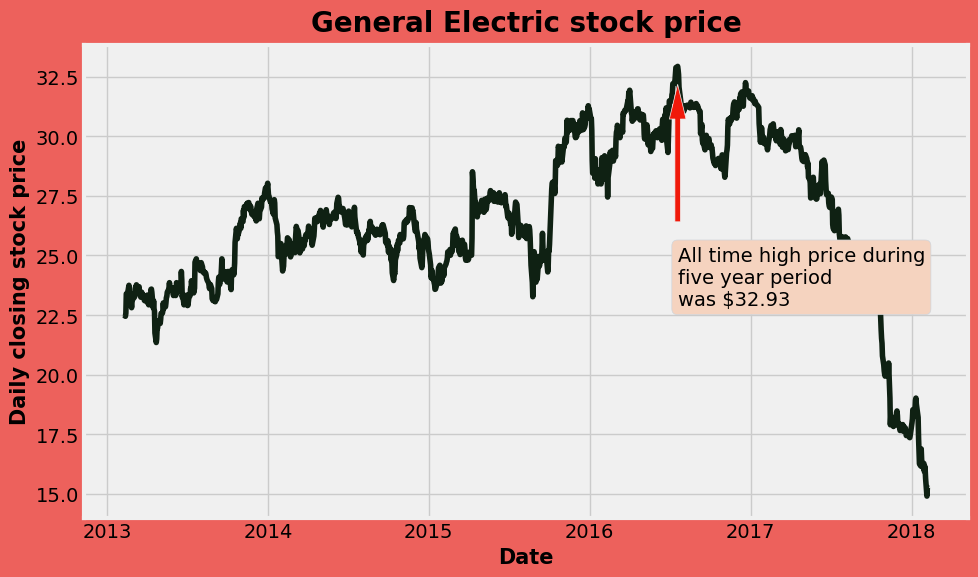

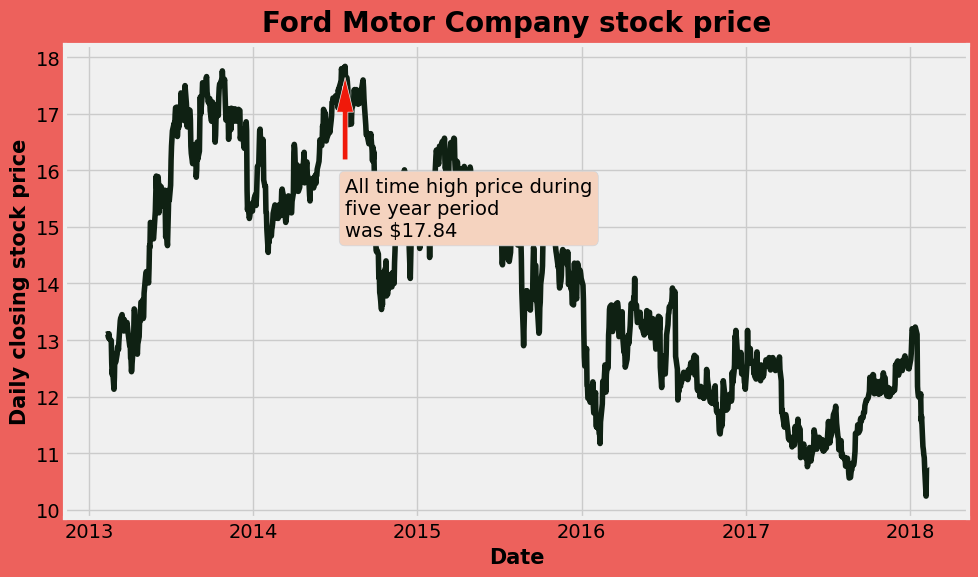

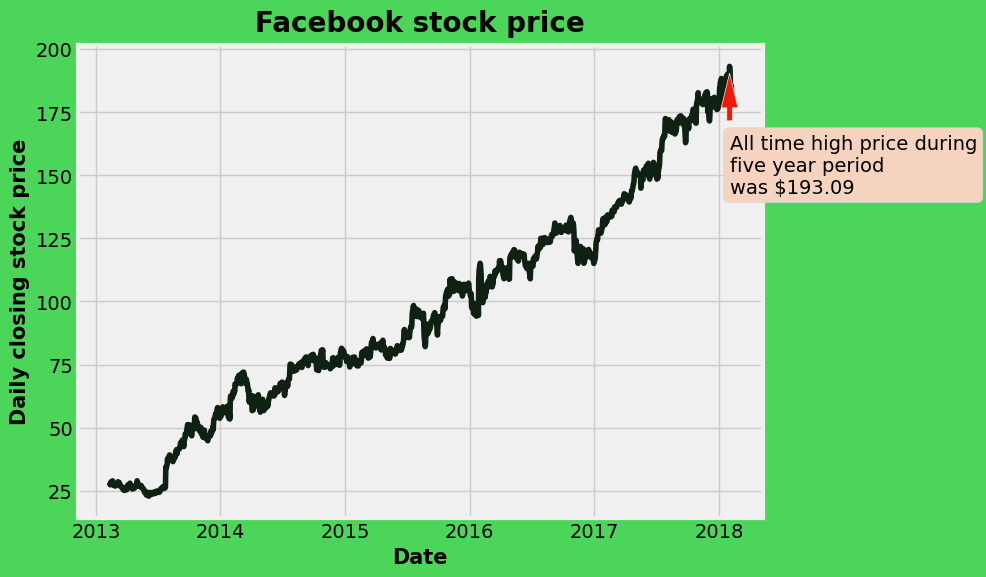

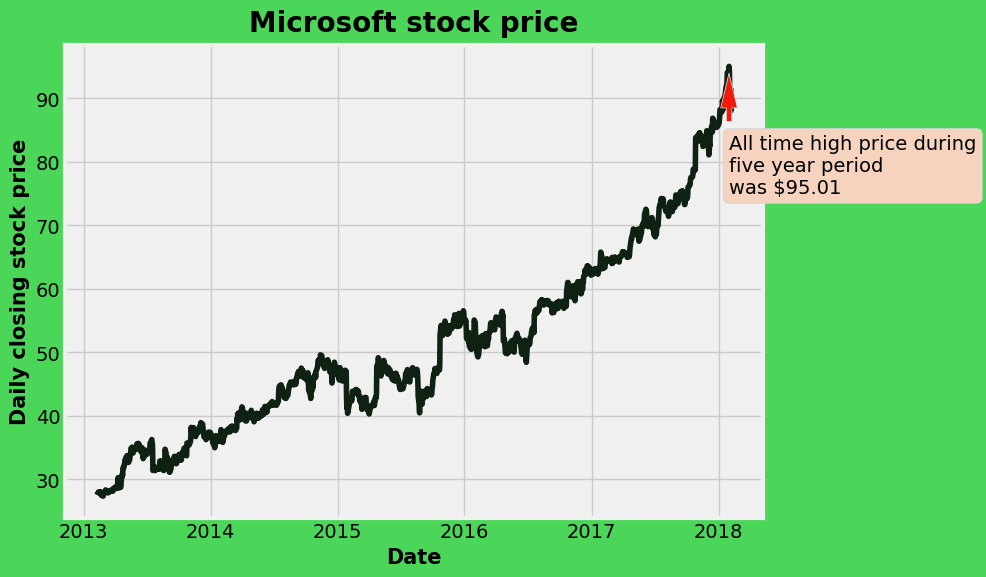

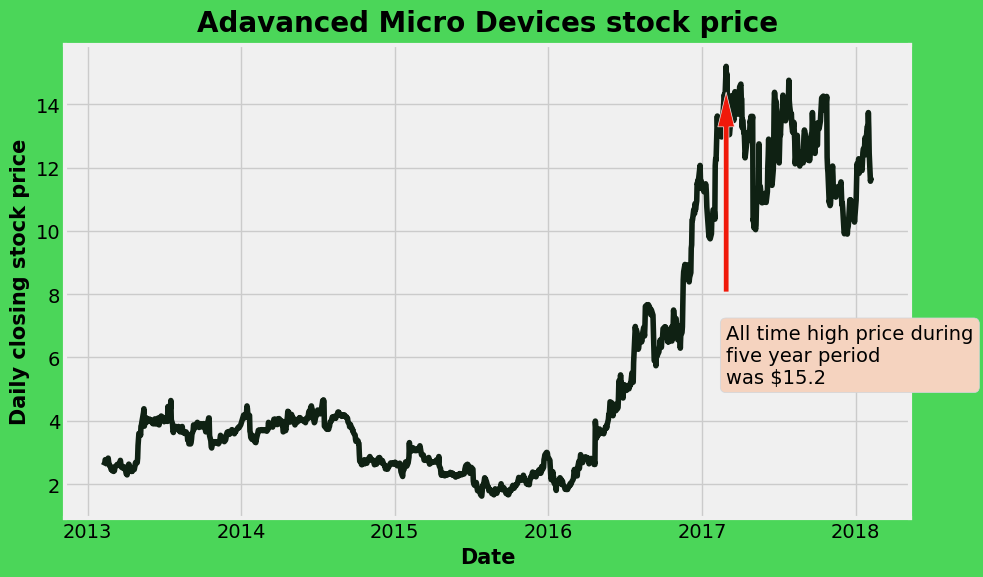

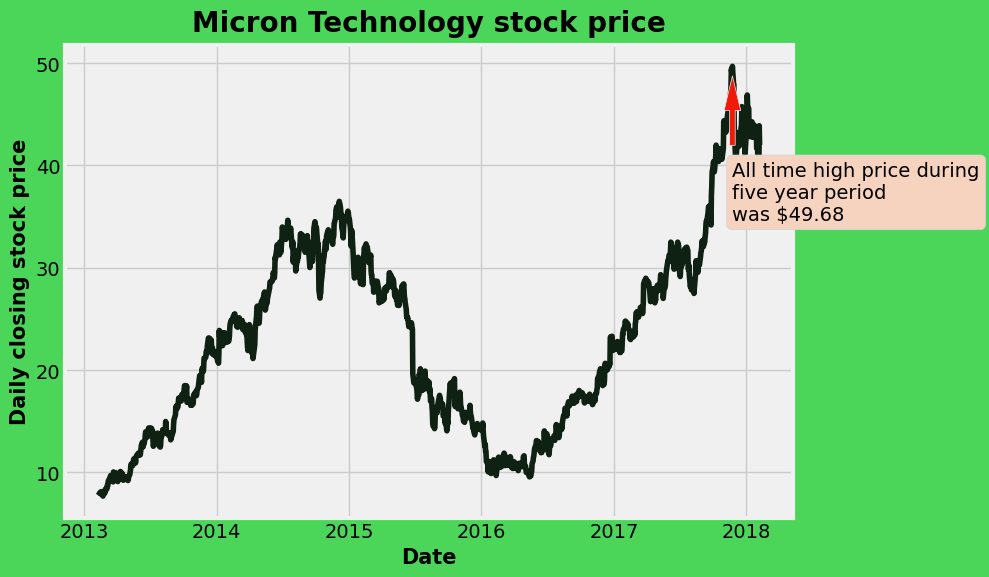

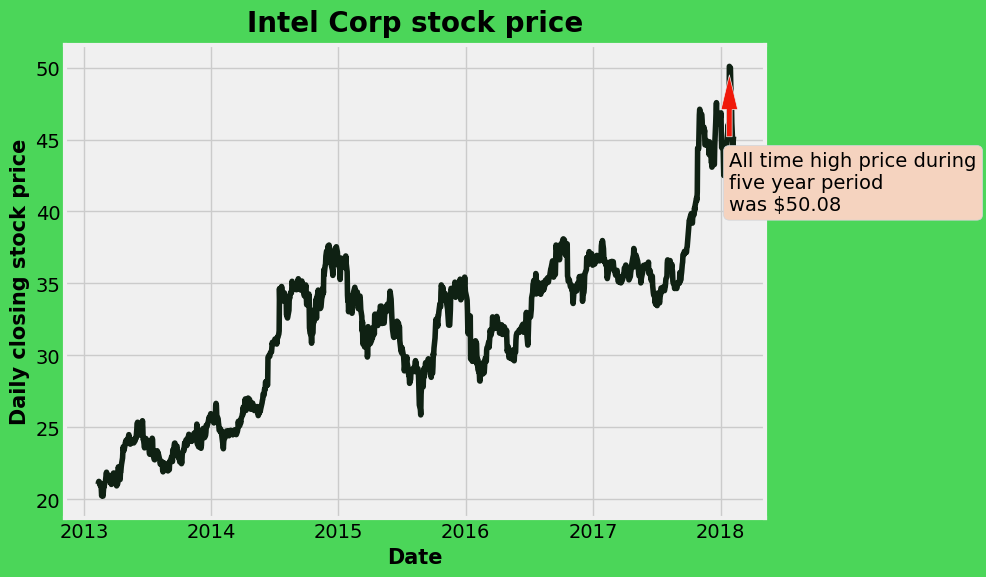

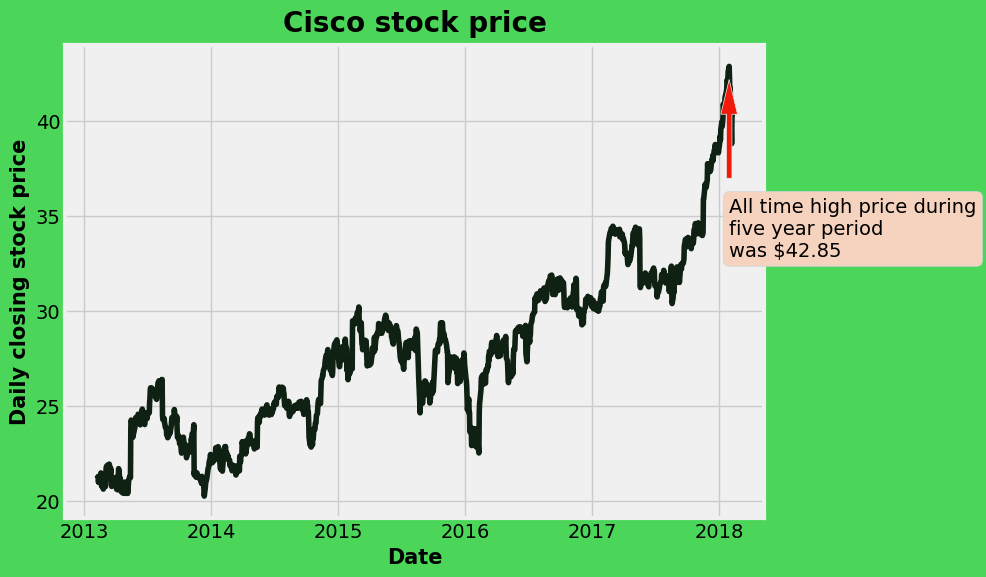

In [32]:
# Function to return the closing stock value and the highest closing stock value over the period of 5 years
def closing_stock_price(df):
    
    #Getting the date when the stock was at its highest closing price
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    #Visualizing the closing price of stocks over 5 years , all the graphs except for Ford and General electric have been 
    #made in green as there value is increasing while GE and F are declining.
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'), arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    
    #plt.savefig(f"{df['co_name'].unique()[0]}.svg", format='svg')
    
    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)

Key Findings:
1. We can find the top 10 most traded stocks during 2013-2018
2. Out of the top 10 companies , 7 are tech companies , 2 are non tech legacy companies and 1 is a bank.
3. We can understand that Ford's and General Electric's stock value is declining.

# <h1 style="background-color:red;color:yellow; padding:10px;">TRADING VOLUME OF STOCKS OVER A PERIOD OF 5 YEARS</h1>

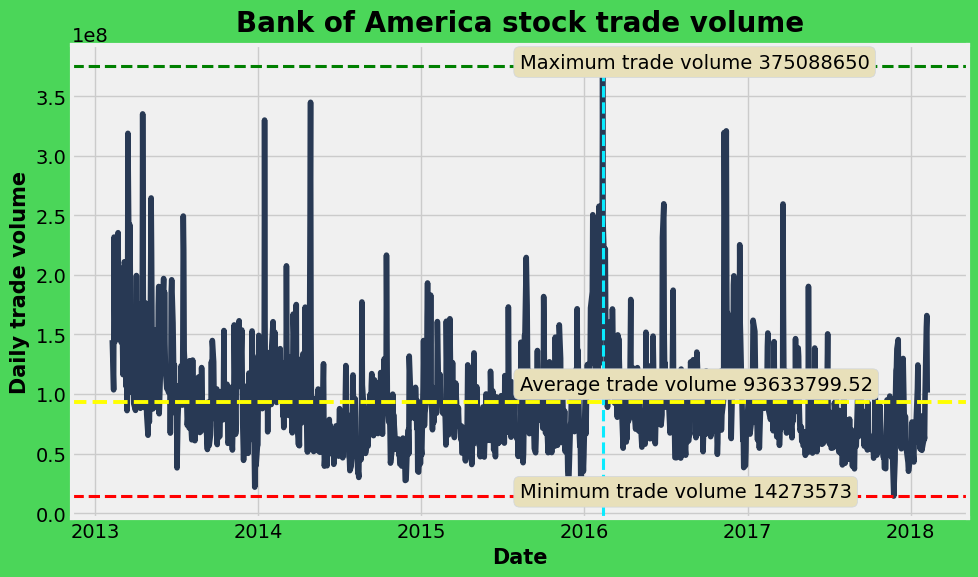

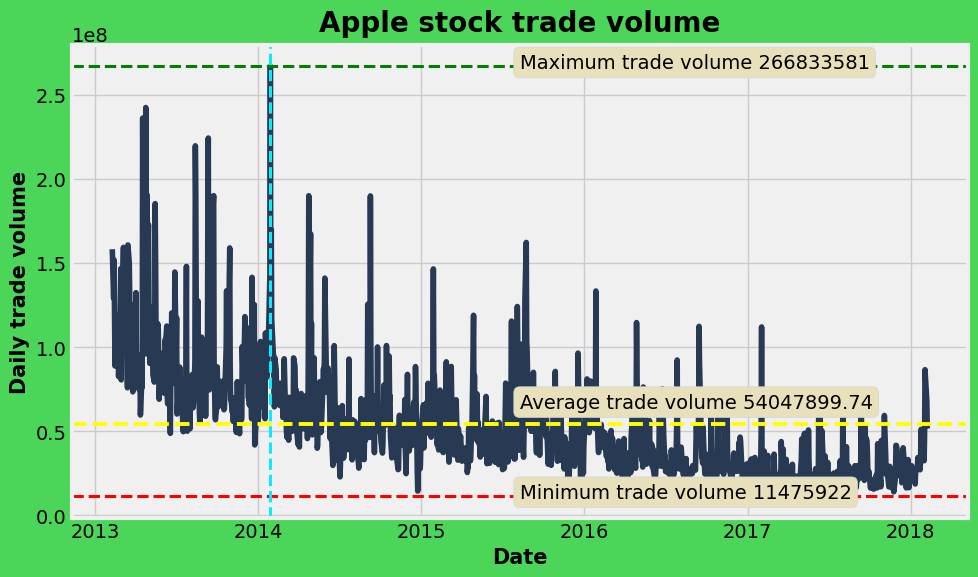

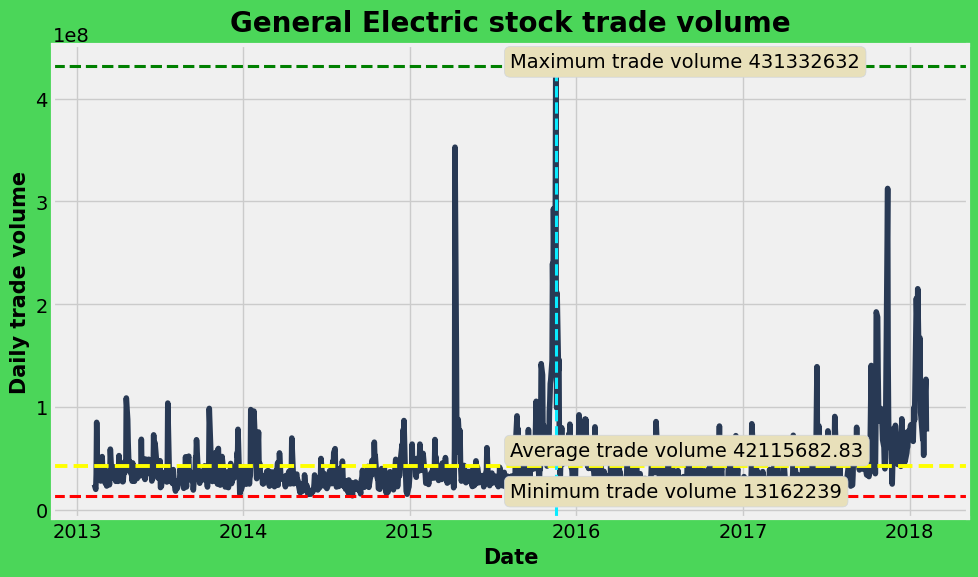

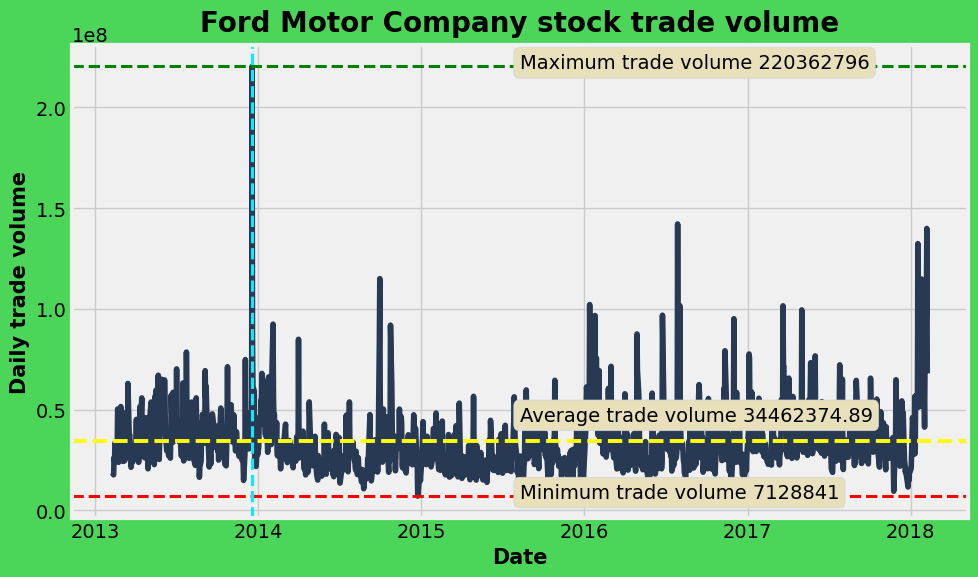

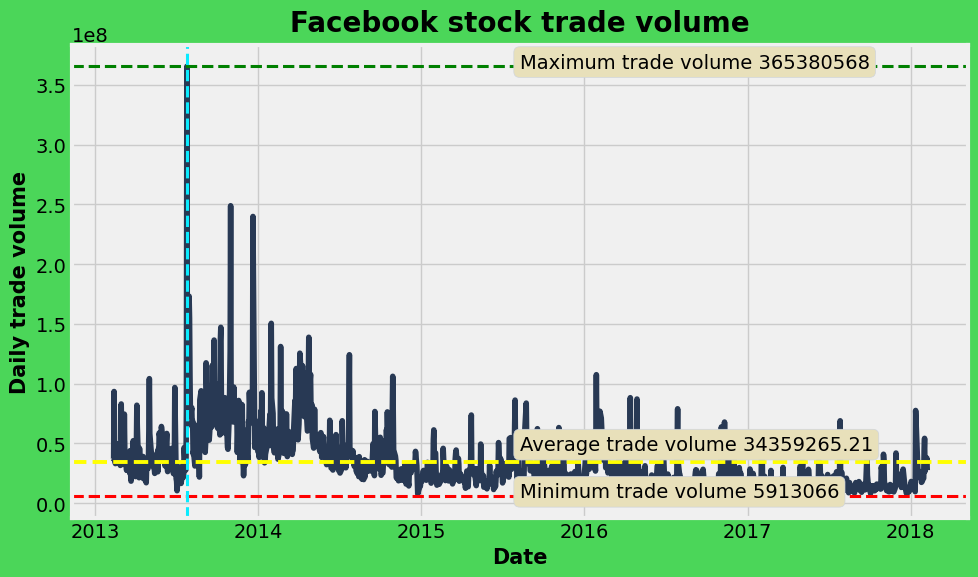

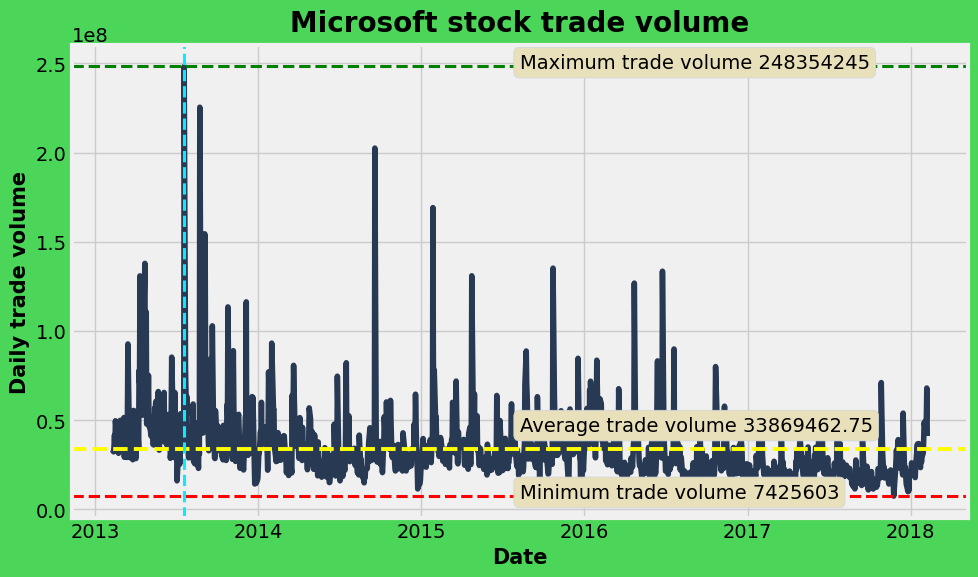

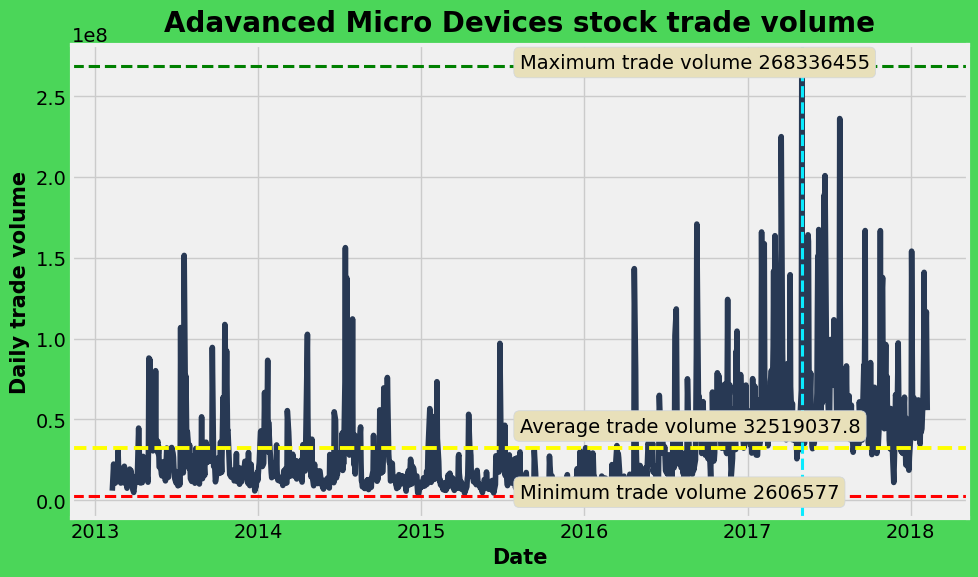

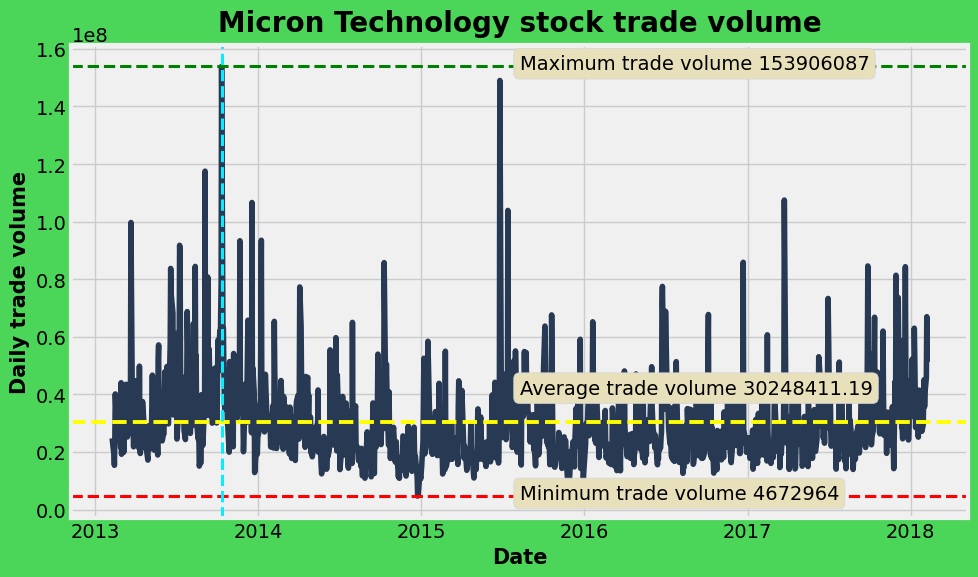

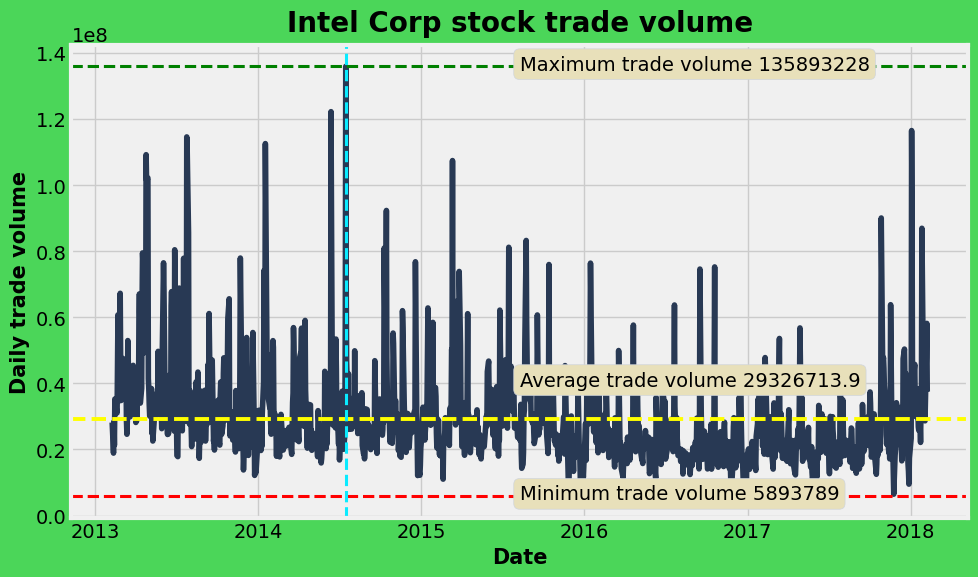

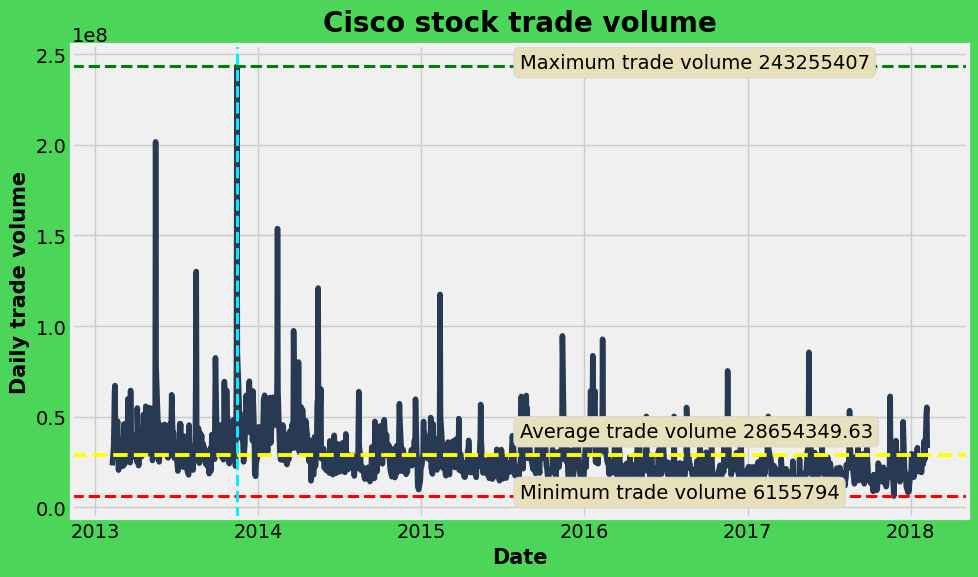

In [33]:
# function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol (Since volume is on y axix the maximum value of volume will be maximum of y coordinate)
    max_y = df['volume'].max()
    # y coord for min trade vol (Since volume is on y axix the minimum value of volume will be maximum of y coordinate)
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    

# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)

Key Findings:
1. We have observed the maximum, minimum and average trade volumes of top 10 stocks over a period of 5 years.
2. INTC' (Intel Corp) has the higest variance in trade volume compared to other stocks.

# <h1 style="background-color:red;color:yellow; padding:10px;">COMPARITIVE ANALYSIS OF THE TECH STOCKS</h1>

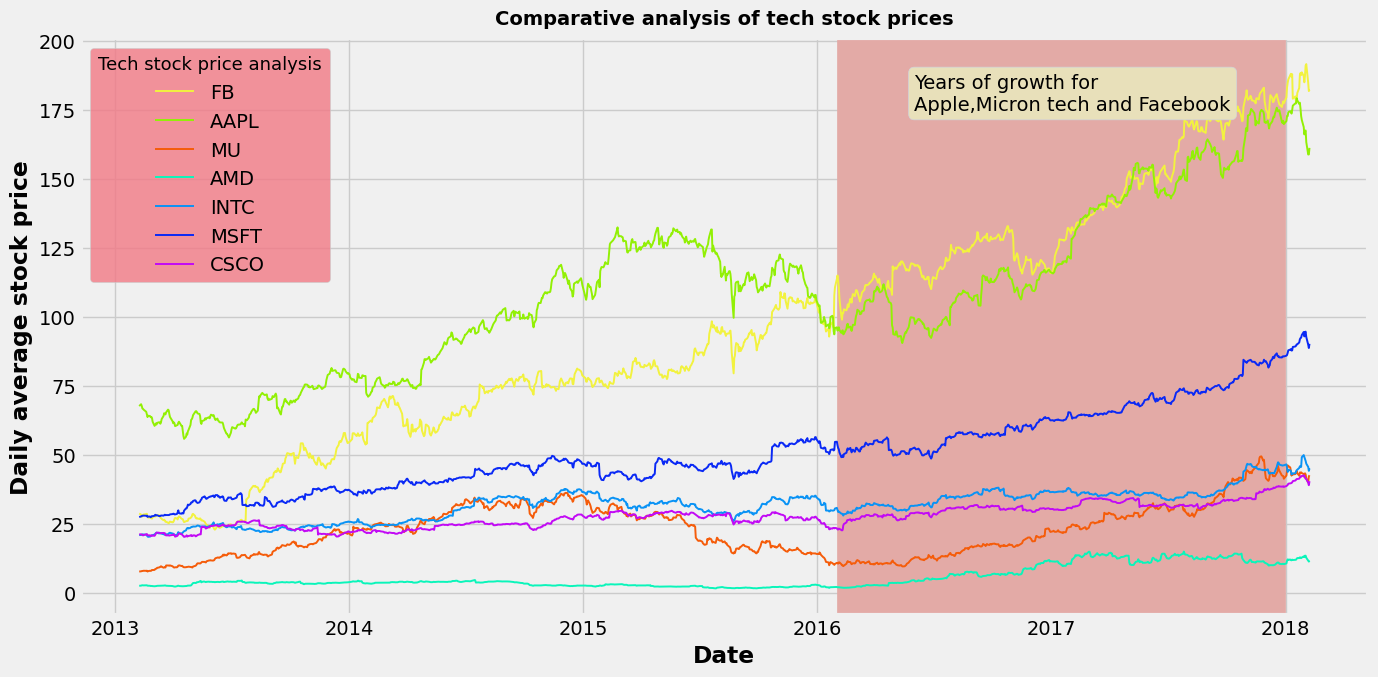

In [34]:
# Plotting a graph to check the comparision of daily mean prices of all 7 tech stocks.

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'],label='FB', color='#f2f23f', lw=1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple,Micron tech and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

Key Findings:
1. 'FB' was the most expensive stock for the later part of 5 years.
2. 'AMD' was the cheapest stock to buy.
3. 'FB' and 'AAPL' were the most volatile stocks during these 5 years.

# <h1 style="background-color:red;color:yellow; padding:10px;">GROWTH OF STOCK PRICES OVER 5 YEARS</h1>

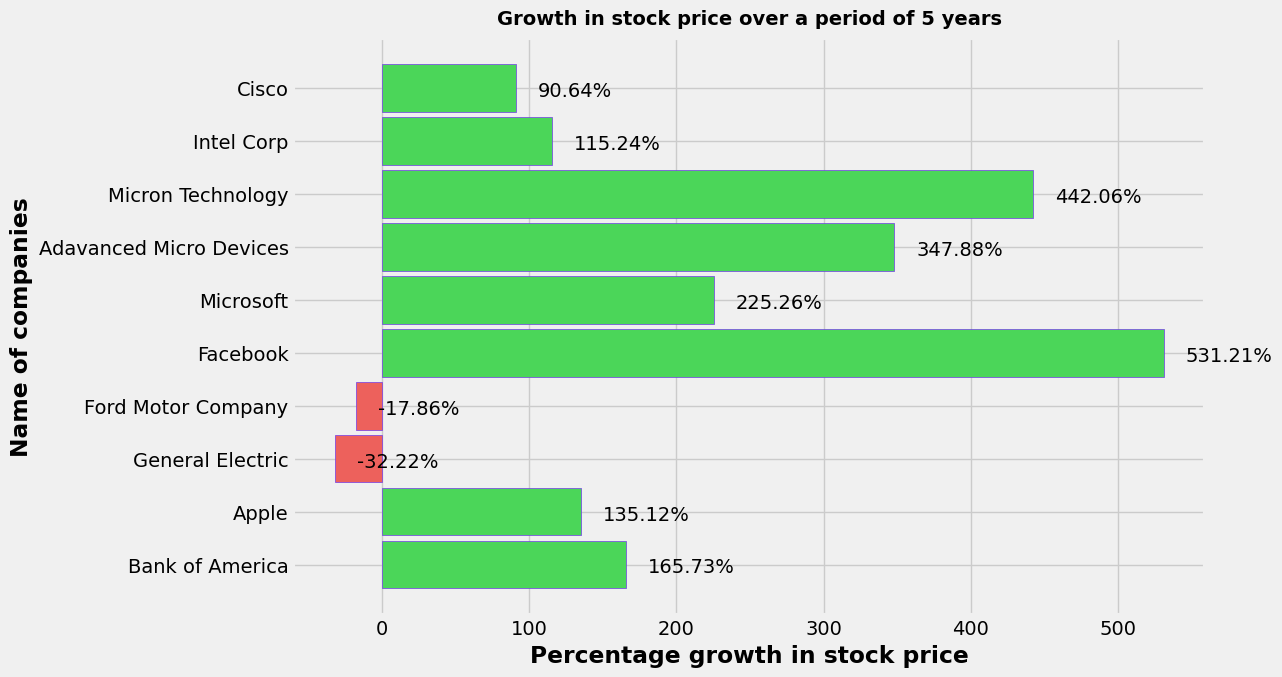

In [35]:
# list of stock dataframes
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

# Finding the initial values(1st value) of each stock and putting them in mini list and putting the final value(end of 5 
# years) in the maxi list
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# Finding the differnce between final and intitial value of each stock and putting them in diff list
diff = np.array(maxi) - np.array(mini)

# find the percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")

plt.show()

Key Observations:
1. Facebook('F') anf Micron Technology('MU') have grown the most in the last 5 years.
2. Ford('F') and General Electrics('GE') are the only two stocks whose value has declined.

#  <h1 style="background-color:red;color:yellow; padding:10px;">DAILY RETURN OF STOCK PRICE ANALYSIS</h1>

1. In finance there has always been a hypothesis that daily return on a stock is 0% , which means you will get 0 returns on your investment in a day. We can test this hypothesis by analy analyzing the top 10 traded stocks with a sample t-test.
2. A sample t_test is used to determine wether a population mean is different from our hypothesized value. It does so by calculating a P value.
3. If the P value is less than 0.05 we have to agree with the hypothesis and if it is greater than 0.05 we have to disagree with the hypothesis.

In [36]:
# python's scipy.stats module has ttest_1samp method we allows to prove this hypothesis
result_dict = {}
for df in list_df:
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result   
result_dict

{'BAC': TtestResult(statistic=-0.3532776176429947, pvalue=0.7239395130534507, df=1258),
 'AAPL': TtestResult(statistic=0.41429430560560776, pvalue=0.6787292124343913, df=1258),
 'GE': TtestResult(statistic=-0.6899014787481074, pvalue=0.4903833915917716, df=1258),
 'F': TtestResult(statistic=-1.829967497402379, pvalue=0.06749132535767648, df=1258),
 'FB': TtestResult(statistic=0.43179923117451596, pvalue=0.6659613318143065, df=1258),
 'MSFT': TtestResult(statistic=2.936864998172622, pvalue=0.00337582087561039, df=1258),
 'AMD': TtestResult(statistic=0.5320769266138293, pvalue=0.5947666691710993, df=1258),
 'MU': TtestResult(statistic=-0.3912233565721498, pvalue=0.6956983959552626, df=1258),
 'INTC': TtestResult(statistic=3.0472693720373076, pvalue=0.002357434011831407, df=1258),
 'CSCO': TtestResult(statistic=2.6892871186777536, pvalue=0.007255138945761972, df=1258)}

1. We can learn that pvalues of stocks 'MSFT'.'INTC' and 'CSCO' are less than 0.05 so we can reject the null hypothesis and accept alternative hypothesis that is 'Daily return is not zero' while for other stocks we cannot reject null hypothesis.
2. Statistically it proves that 7 out of 10 have daily return of zero percentage which is the most general case.

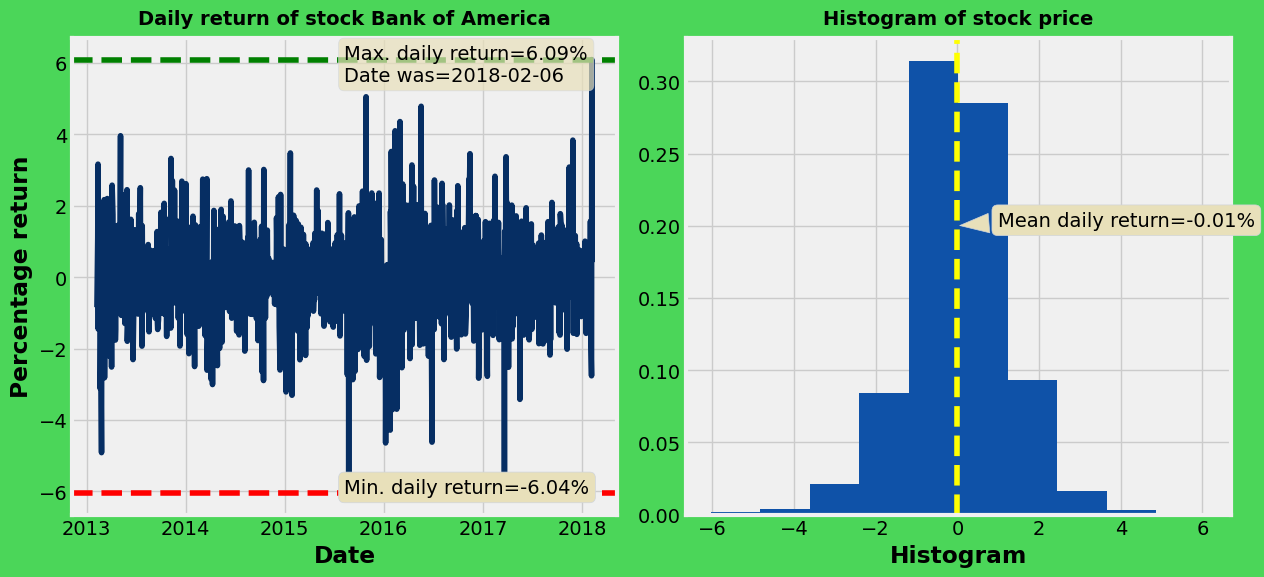

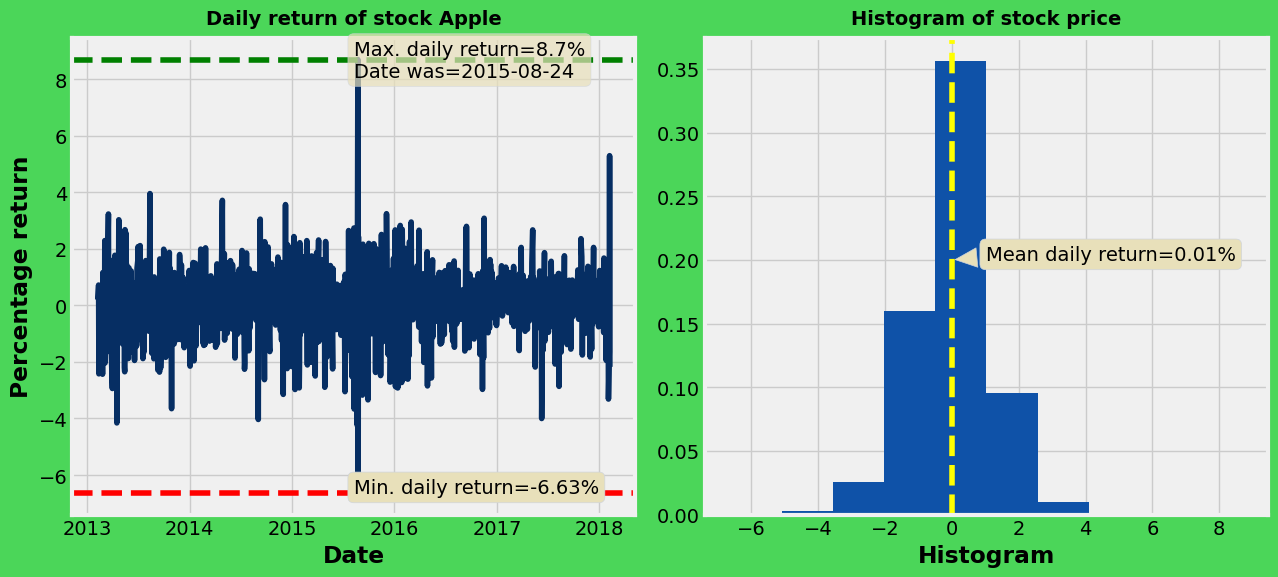

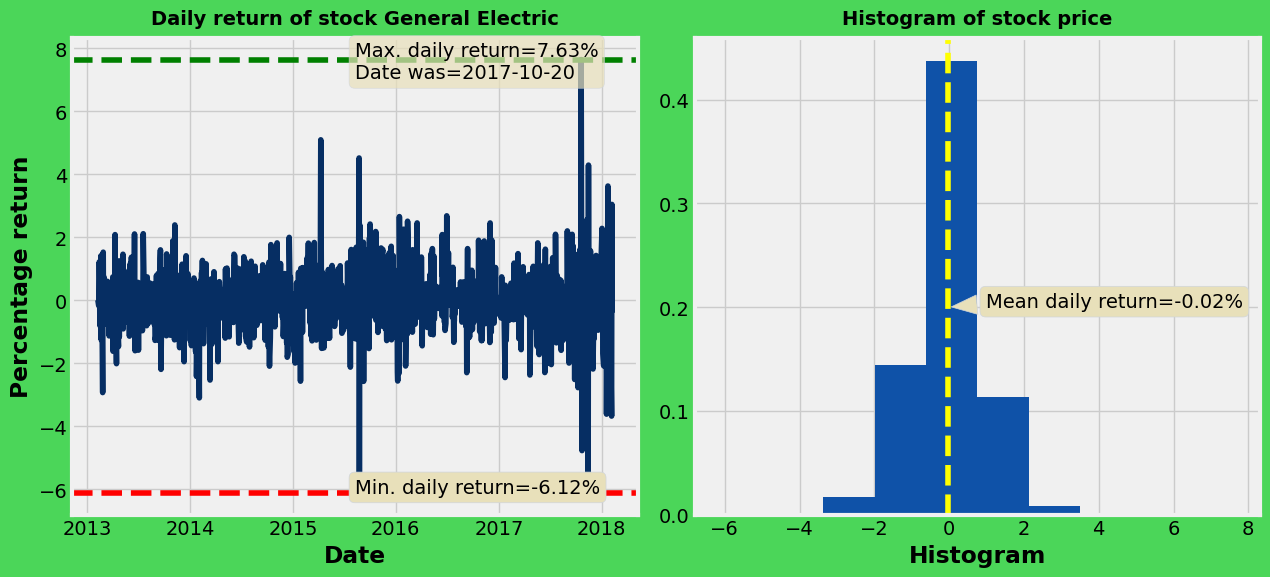

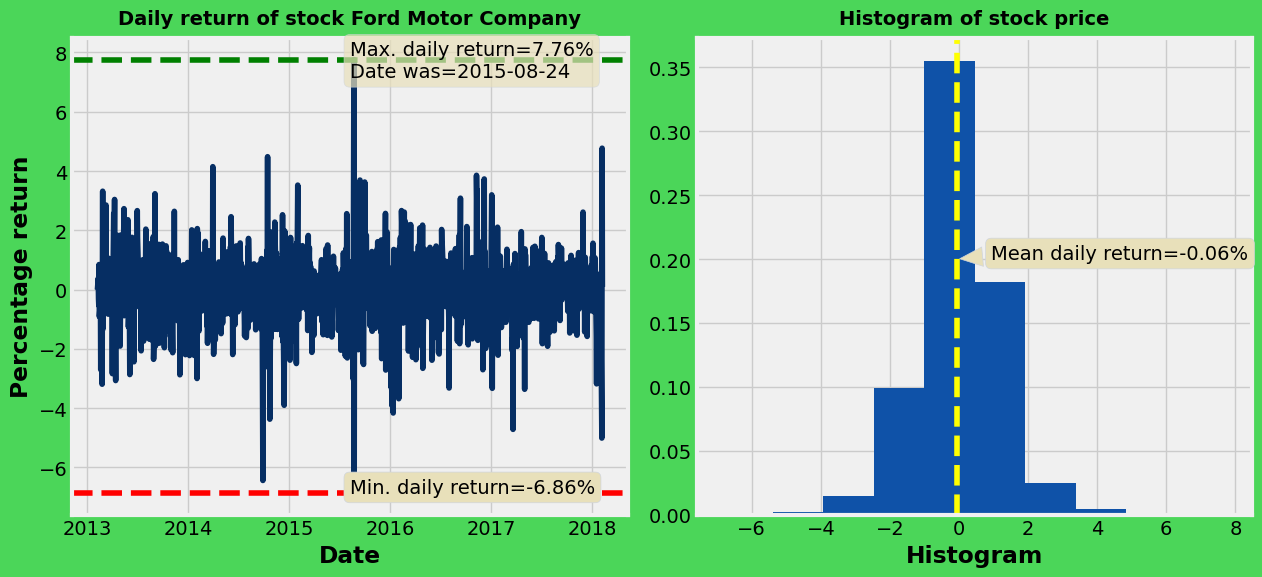

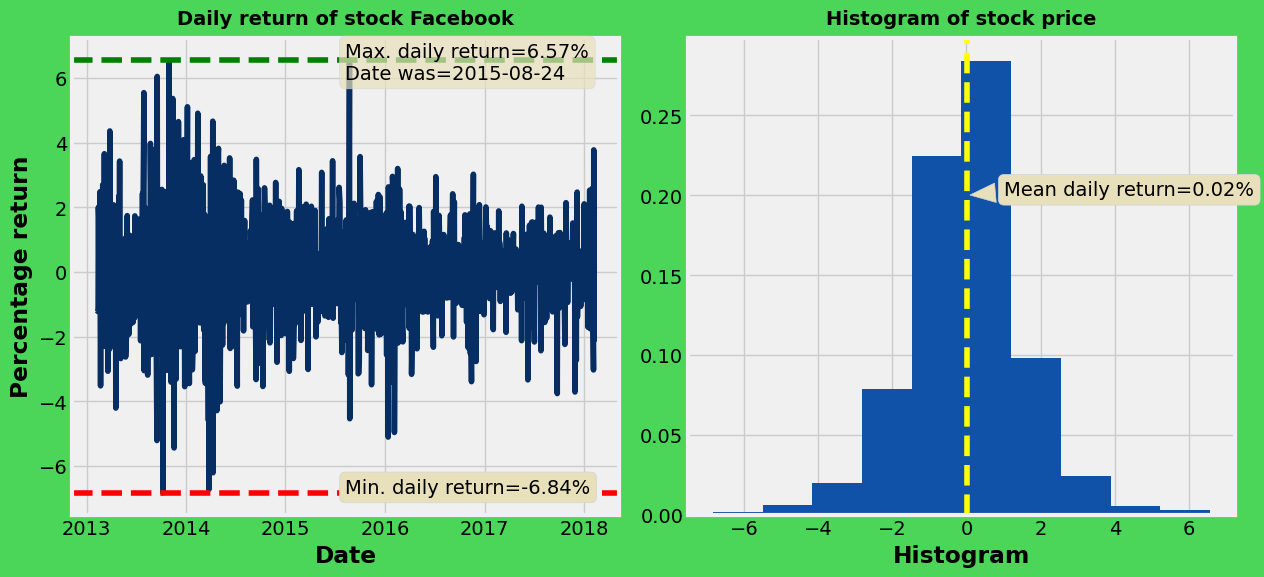

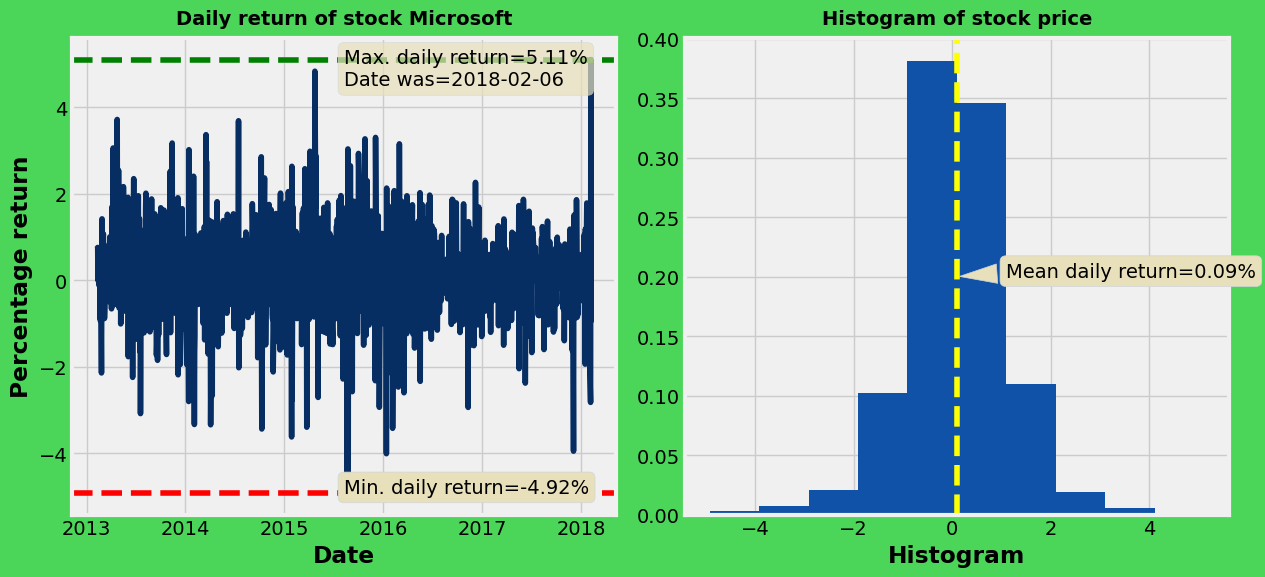

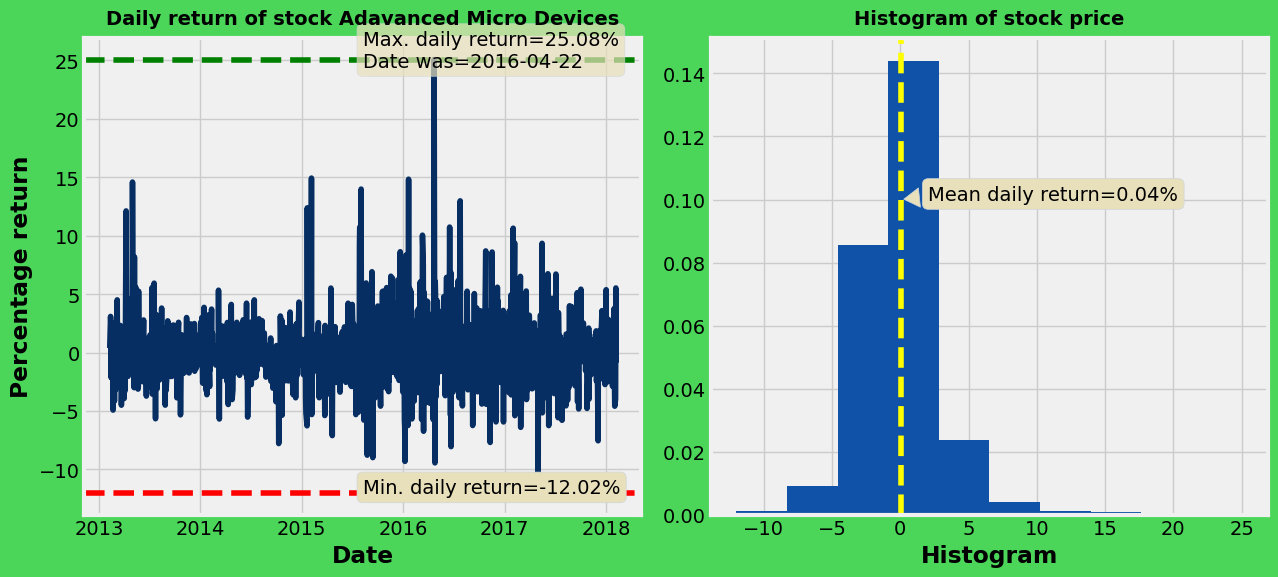

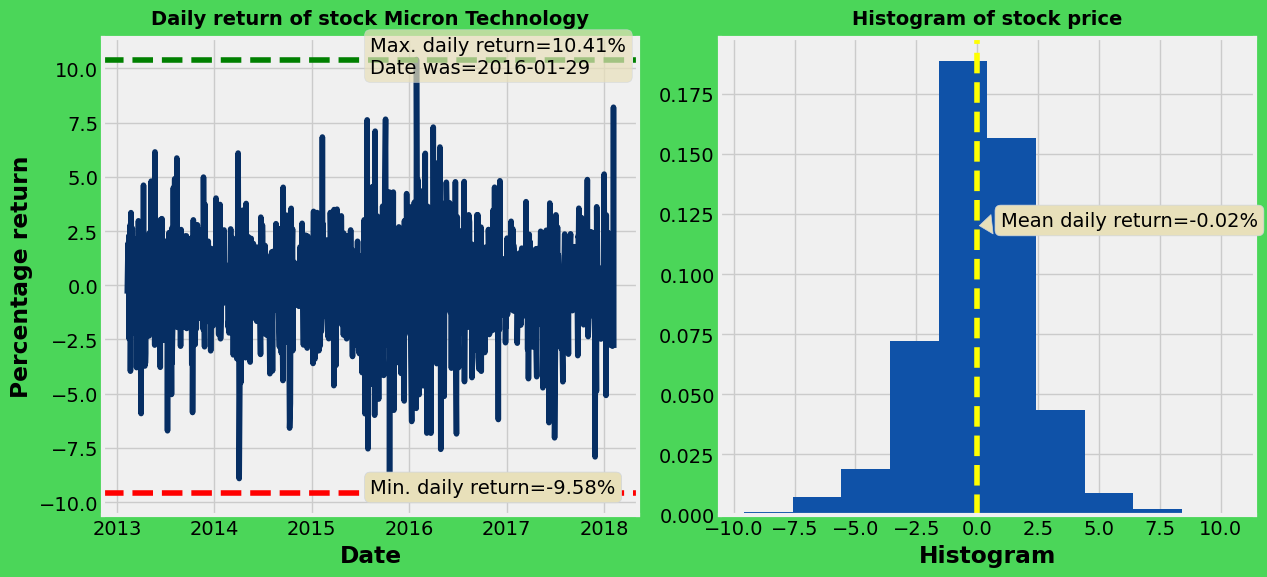

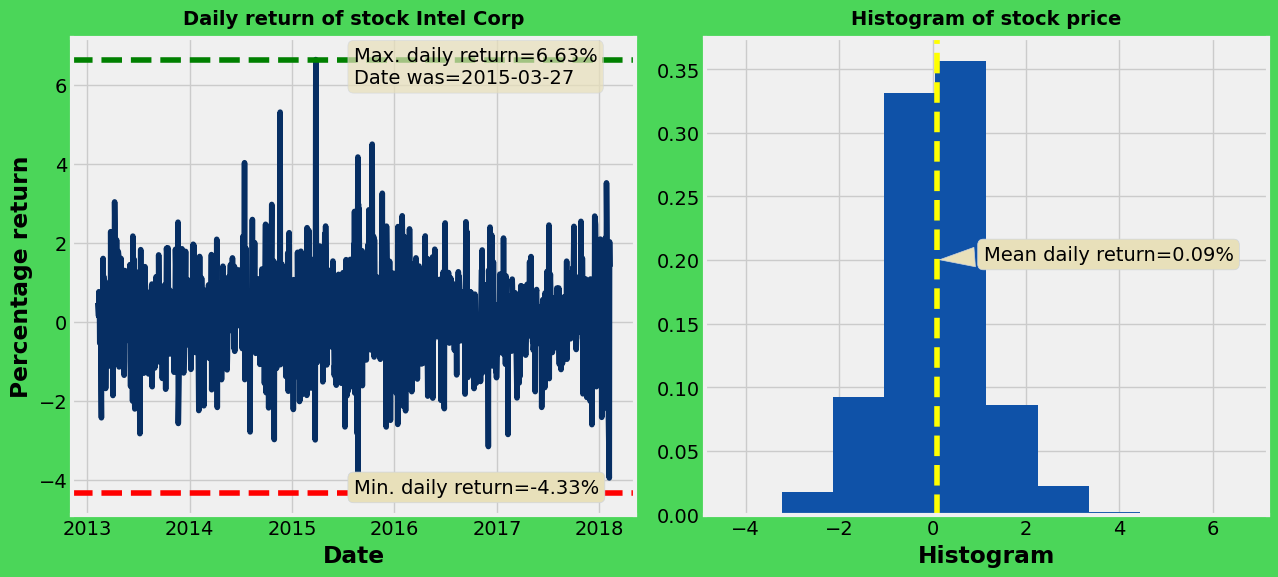

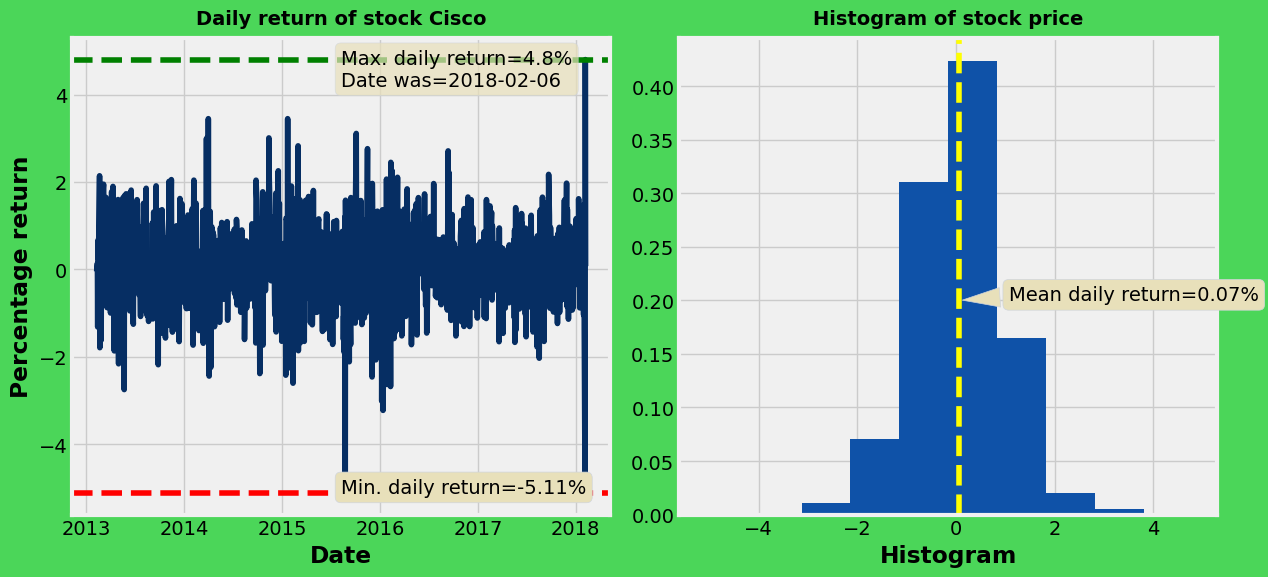

In [37]:
###### function to plot daily return and histogram of 10 stocks
def daily_return(df):
    
    # assign variables to annotation positions
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()
    
    plt.figure(figsize=(13,6), facecolor='#4bd659')
    
    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color='#062e63')
    plt.axhline(y=df['daily return'].max(), color='green', ls='--')
    plt.axhline(y=df['daily return'].min(), color='red', ls='--')
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Min. daily return={round(df['daily return'].min(),2)}%", 
                xy=(ave_x,y_min),xytext=(ave_x,y_min),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    plt.annotate(f"Max. daily return={round(df['daily return'].max(),2)}%\nDate was={xb}", 
                xy=(ave_x,y_max),xytext=(ave_x,y_max-0.6),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db', alpha=0.7)
                 )
    plt.title(f"Daily return of stock {df['co_name'].unique()[0]}")
    
    plt.subplot(122)
    plt.hist(df['daily return'], density=True, color='#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x=df['daily return'].mean(), color='yellow', ls='--')
    if df['ticks'].unique()[0] == 'AMD':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.10),xytext=(y_mean+2,0.10),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.12),xytext=(y_mean+1,0.12),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    else:
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.20),xytext=(y_mean+1,0.20),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    plt.title(f"Histogram of stock price")
    
    plt.show()

    # call the function with dataframe
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

<h1 style="background-color:red;color:yellow; padding:10px;">MOVING AVERAGE CHARTS OF FACEBOOK AND APPLE</h1>

Moving Average is a very common tool used in technical analysis, what it does is it doesn't focus on the closing value of just 1
day it focusses on the average of closing values over a period of time. This helps in neglecting short term fluctuations and focussing on long term patterns and trends. Now, instead of calculating average once we keep on updating it everyday. For example we are calculating moving averages ovr a 10 day period on a dataset which has dates from Jan 1 2023 to jan 31 2023, then the first average will be calculated from 1st jan to 10th Jan and the second average will be calculated from 2nd Jan to 11th Jan and so on. By constantly updating this data we can see the overall trend more clearly.

Moving average is one of the most widly used stock market forecasting method in finance industry, in this section we will plot and analyse stocks of 'FACEBOOK' and 'APPLE' using 10, 50 and 200 days moving averages to find uptrend and downtrends

In [38]:
#Rolling mean -> Calculating mean of a specified window size

# define function to return copies of stock dataframe with moving averages
def mav_function(df):
    
    # calclulate moving averages of 10,50 and 200 days
    
    #This line will calcuate the average of last 10 closing prices for each data point and if a data point doesn't have 10
    #entries before it it will just have Nan input in the column
    df['10_d_avg'] = df['close'].rolling(window=10).mean()   
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()
    
    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [39]:
# plot moving avearges charts of apple and facebook
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    # set colors and cols names to be plotted
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']
    
    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)
        
    fig['layout'].update(height=800,title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}",
                    paper_bgcolor='#4bd659', plot_bgcolor='#F2DFCE')
    fig.show()

In [40]:
# plot the MAVs fo FB
mav_chart(fb_dfn)

Analysis and interpretation:
1. Over a period of 5 years FB showed upward trend except only one time which was around Dec. 2016, and reason of that decline was FB got into trouble by reports of 'Cambridge analytica Data scandle', thus stock declined in Dec. 2016

In [41]:
mav_chart(aapl_dfn)

Analysis and Interpretation:

1. Apple's stock price shows more irregular fluctuations compared to FB with one major decline during period of 2015-16.
2. Around 7th august 2015 10 Days Moving average of Apple's stock price goes below 200 Days Moving average which shows downward trend in apple's stock price.
3. And exactly, year after 15th august 2016, 10 Days Moving average crosses 200 Days Moving avearge which show uptrend thereafter.
4. By comparing stocks 'FB' and 'AAPL', we can conclude that 'FB' performed better than 'AAPL'. 'FB' showed more consistant growth as well as less fluctions than 'AAPL' which proves the performance of 'FB' stocks. My recommendation is to BUY 'FB' as it has great growth prospects.

# <h1 style="background-color:red;color:yellow; padding:10px;">STOCK PRICE FORECASTING</h1>

In [42]:
# Formatting the dataframe for model training
def df_formatting(df):
    #This will keep all the rows and keep only the 2 specified columns
    df = df.loc[:, ['date','close']]
    #This renames date column to ds and close column to y this is typical formatting where ds represents date/time and y 
    #represents target variable
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True) 
    
    return df

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)

Time-Series Decomposition:
It involves thinking of series as combination of level, trend, seasonality and noise components. For example if we have a temprature graph then the average temprature could be considered as the level, if the temprature gets hotter or colder over time that would be considered a trend, sudden spikes in temprature for a day or two because of external factors such as storms or heatwaves can be considered noise, seasonal data is data that occurs on repating patterns or cycles.

In [43]:
# Function to find  seasonal decomposition of time-series models
def decomposition(df, period):
    #Creating a decompistion instance using the seasonal_decompose function from statsmodel library, it decomposes time 
    #series data df['y'] into its trend,seasonal and residual components. additive model means that the decomposed components
    #can be added together to reconstruct the orignal series, period means setting the length of the seasonal component, if 
    #there are going to be any missing values then we will look at how often the data is recorded and use that pattern to 
    #guess the missing values for example if we are recording data and have missing values then we will look at daily data and
    #guess missing val
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))    #Setting the size of plot as 10 inches tall and 6 inches wide
    # Tight layout to realign things
    fig.tight_layout()    #Avoids overlapping
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

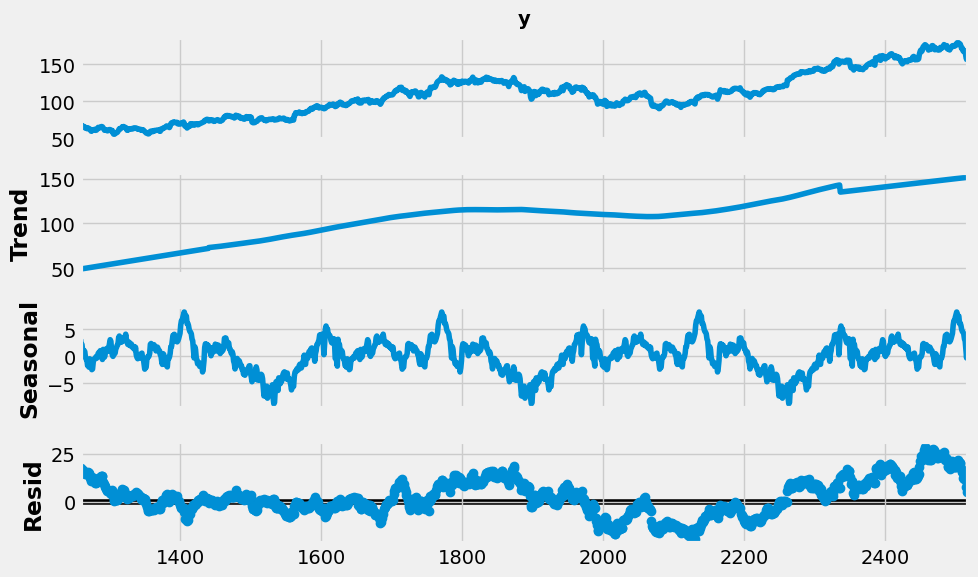

In [44]:
# Decomposed components for aapl stock price
tr, se, re = decomposition(aplph_df, 365)

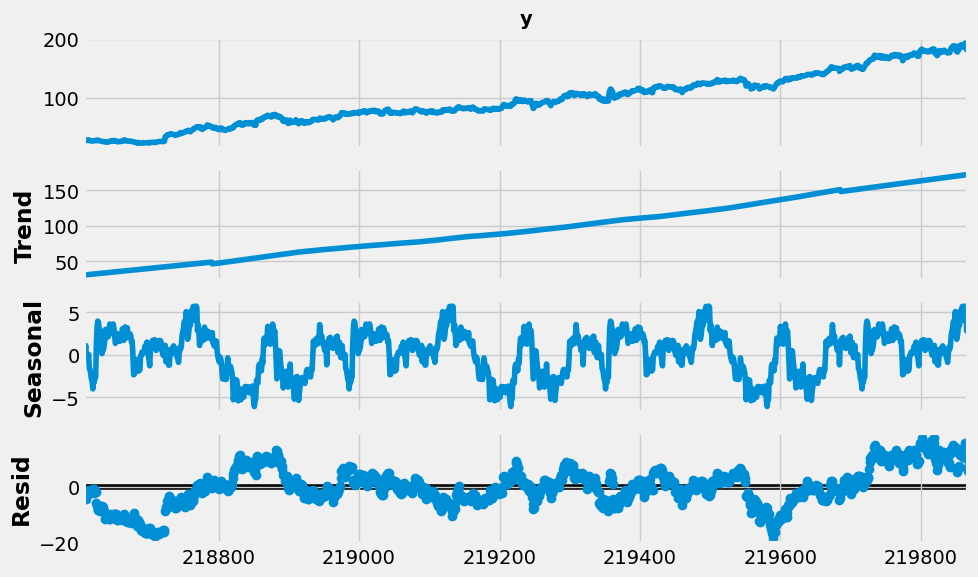

In [45]:
# Decomposed components for fb stock price
tr, se, re = decomposition(fbph_df, 365)

Plotting the autocorrelation and partial auto-correlation plots

In [46]:
# function to retunr acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((10, 5))
    fig.tight_layout()
    plt.show()
    
    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((10,5))
    fig.tight_layout()
    plt.show()

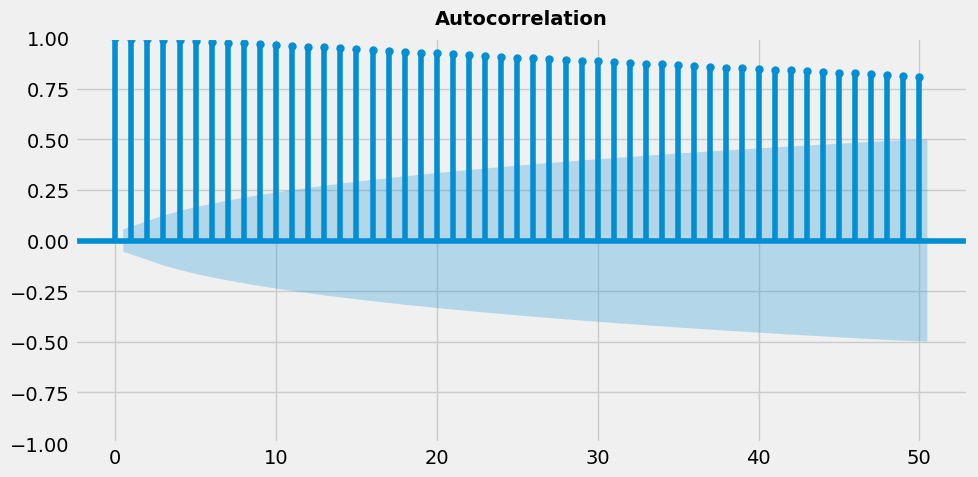

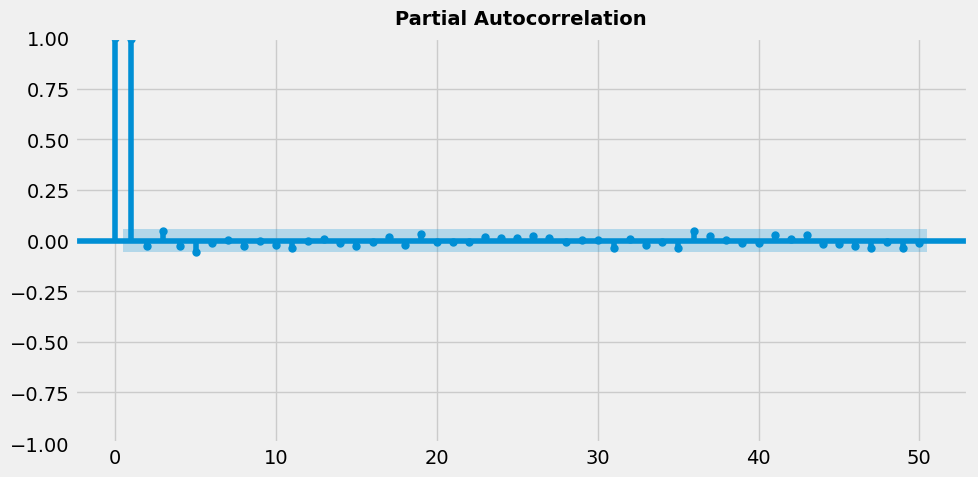

In [47]:
# acf and pacf of aapl stock 
acf_pacf(aplph_df, 50)

1. In both the PACF graphs there is significant correlation at lag 1 and not at other lags, this signifies that the time series exibhits a simple pattern of dependance where each pattern is primarliy influenced by its immediate predecessor.
2. Slow decline in auto-correlation indicates time-series is not stationary as the past observations are influencing the current observations

In [48]:
# Differencing means computing the difference between consecutive values this can help in seeing the underlying patterns or
# fluctutations in data.It also makes the series more stationary which is necessary for time series modeling and we can
# make more reliable predictions with it.

#Since the time series is not stationary we will find out the degree of differencing to make it stationary
def degree_of_differencing(df, co_name):
    #ndiffs function calculates the degree of differncing required to make series stationary and use the Augmented dickey 
    #fuller test to determine stationarity
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')
    
    return company_ndiffs

aapl_ddf = degree_of_differencing(aplph_df, 'APPLE')
fb_ddf = degree_of_differencing(fbph_df, 'Facebook')

The degree of differencing is 1 for APPLE
The degree of differencing is 1 for Facebook


# <h1 style="background-color:red;color:yellow; padding:10px;">USING ARIMA TO TRAIN MODEL</h1>

In [49]:
# Function to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    #This decides the index to split training and testing data 95 percent for training 5 for testing
    size = int(len(df)*0.95)    
    train_df = (df['y'])[:size]    #this selects the first 95 percent(0-95) for training
    test_df = (df['y'])[size:]    #this selcts the first 5 percent(5-end) for testing
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')

data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1196, Test Size: 63
-------------------------------


Using ARIMA(Autoregressive Integrated Moving Average) to fit our data. It can be understood by it's components:
1. Autoregression(AR): It means how the current value is effected by its past lagged values.
2. Integration(I) : It means making the data set more predictable by removing trends in the graph, this is done through differencing.
3. Moving Aevrage(MA): It looks at the current observation in the time series and compares it with a nearby average. This helps in ignoring short term malfunctions and helps on focussing on long term patterns.

In ARIMA , we estimate the values of parameters through statistical testing. Then these parameters are used to estimate the 
relationship between current value in the time series and its past values and errors(prediction Vs actual value). This estimation is done by looking at patterns and correlation in the data.

In [50]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    #Finding the best fit armia model(finding optimal parameter selection) for given time series data ,adf test is used for 
    #stationarity determination  and Akaike Information Criterion (AIC) is  used for model selection
    
    #p(autoregressive order) : The number of lag observations in the model
    
    #d(differencing order) : The number of times raw observations are differenced to make dataset stationary, if left to none
    #it will be automatically determined by the algo based on tests
    
    #q(moving average order): The size of the moving average window.
    
    #seasonal = True means that seasonal patterns will also be considered , start_P is similar to start_p but for the seasonal
    #component , m represents the period of seasonality(here 3 means 3 months), D is for the seasonal differnecing order
    
    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

model_apl = find_best_fit_arima(apl_train, 'APPLE')
model_fb = find_best_fit_arima(fb_train, 'FB')

Arima model for APPLE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=5737.373, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=4795.557, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=5191.240, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=5746.692, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=5067.196, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=4657.095, Time=1.01 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=4.44 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=5740.397, Time=0.54 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=4647.664, Time=1.09 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=4777.434, Time=0.51 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   

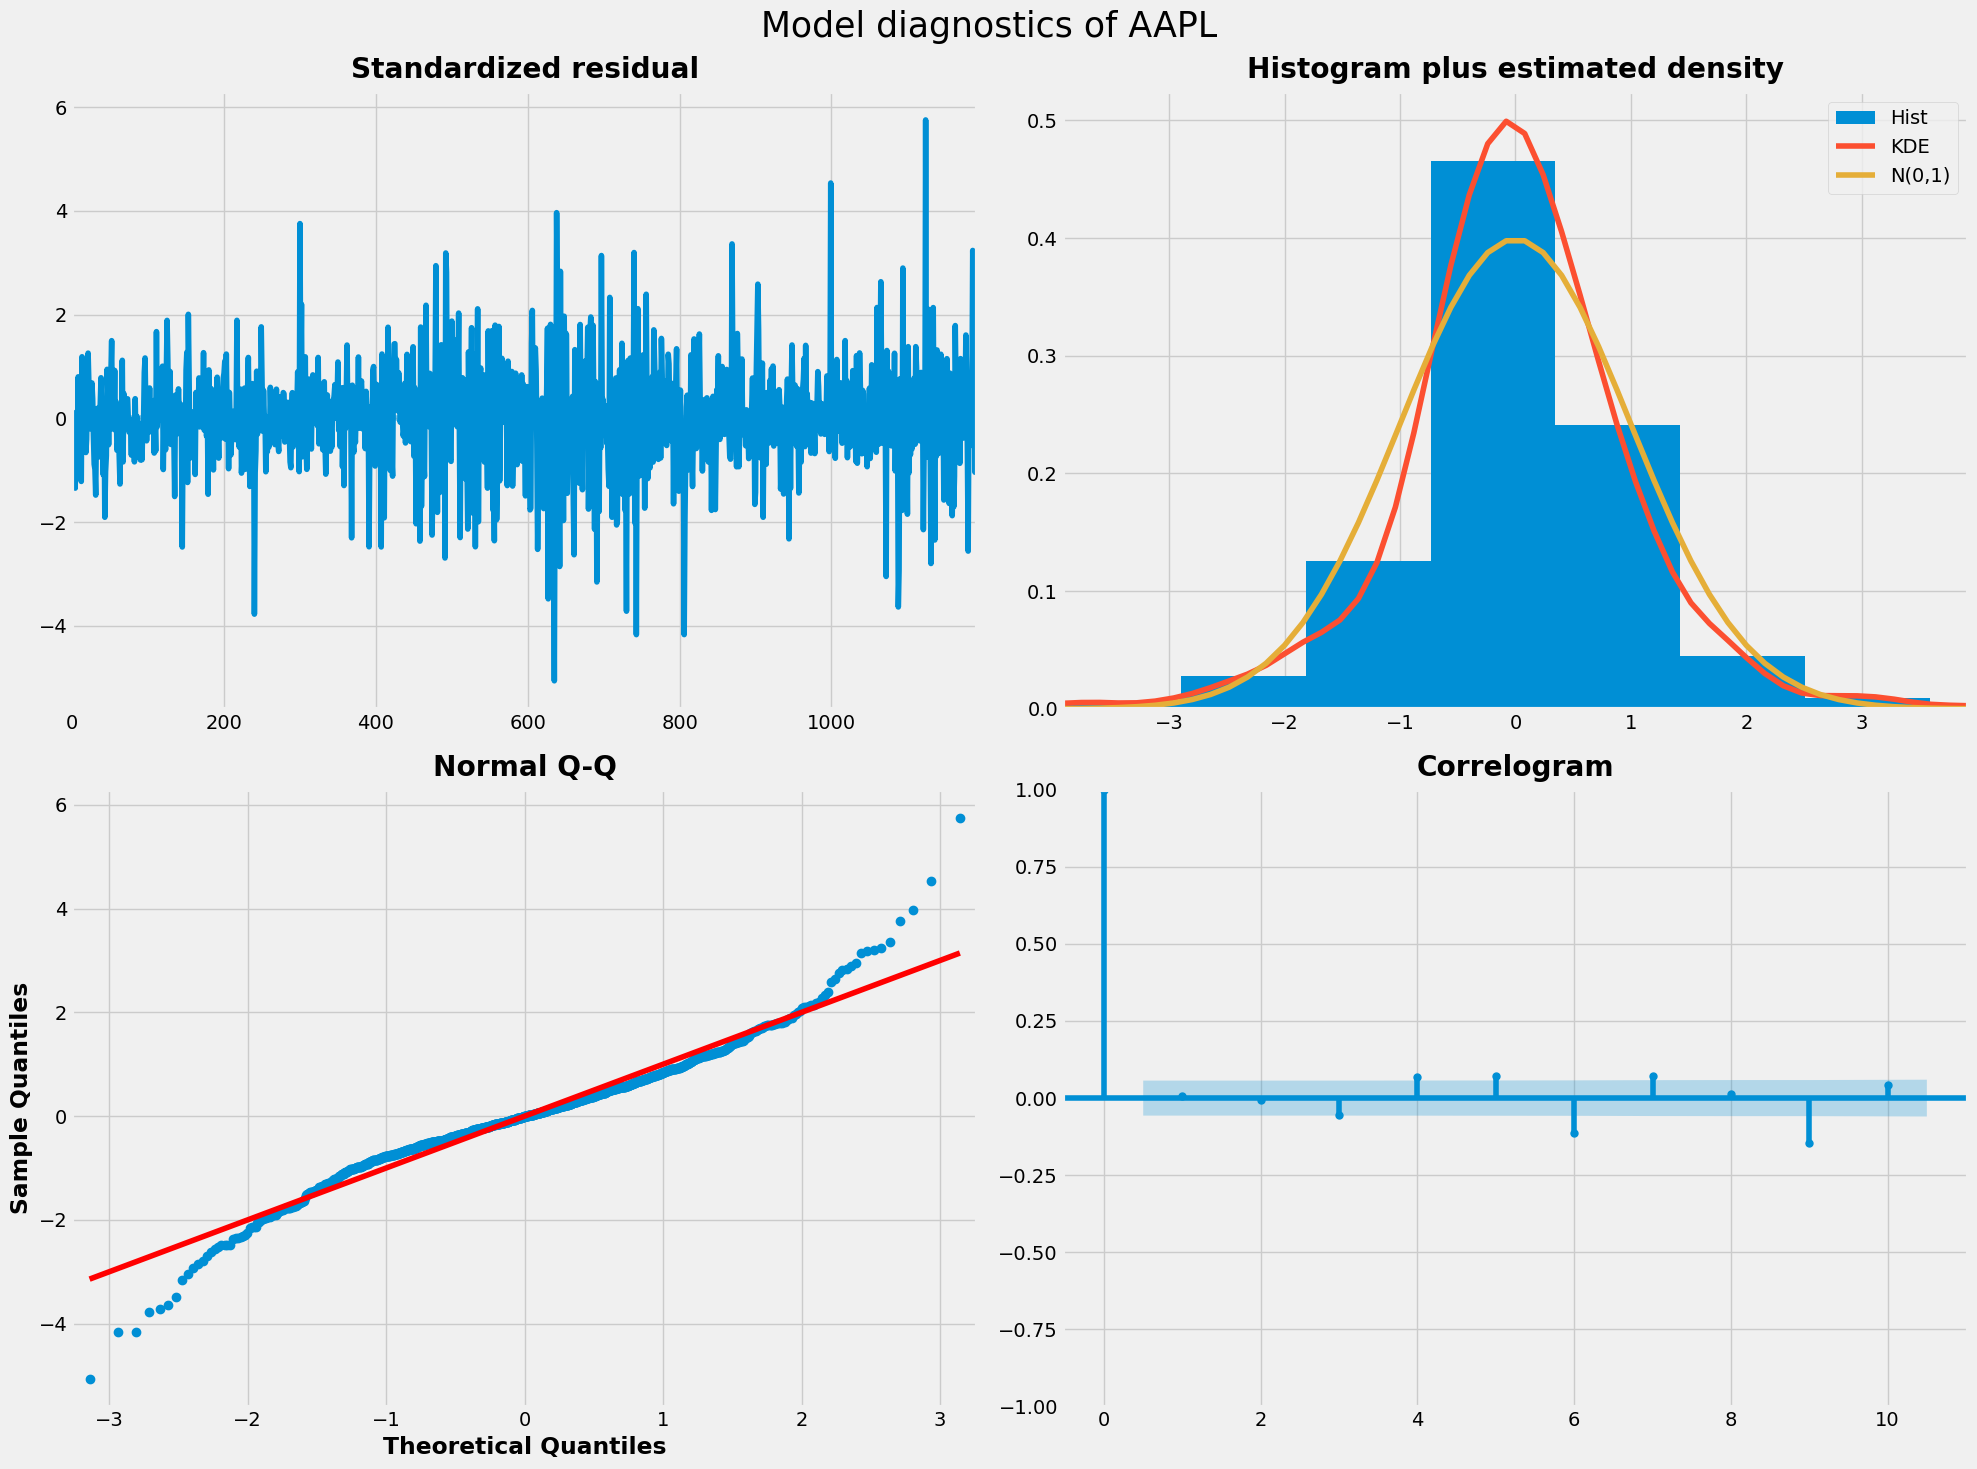

--------------------------------------------------------------------------------------------------------------------------------------------


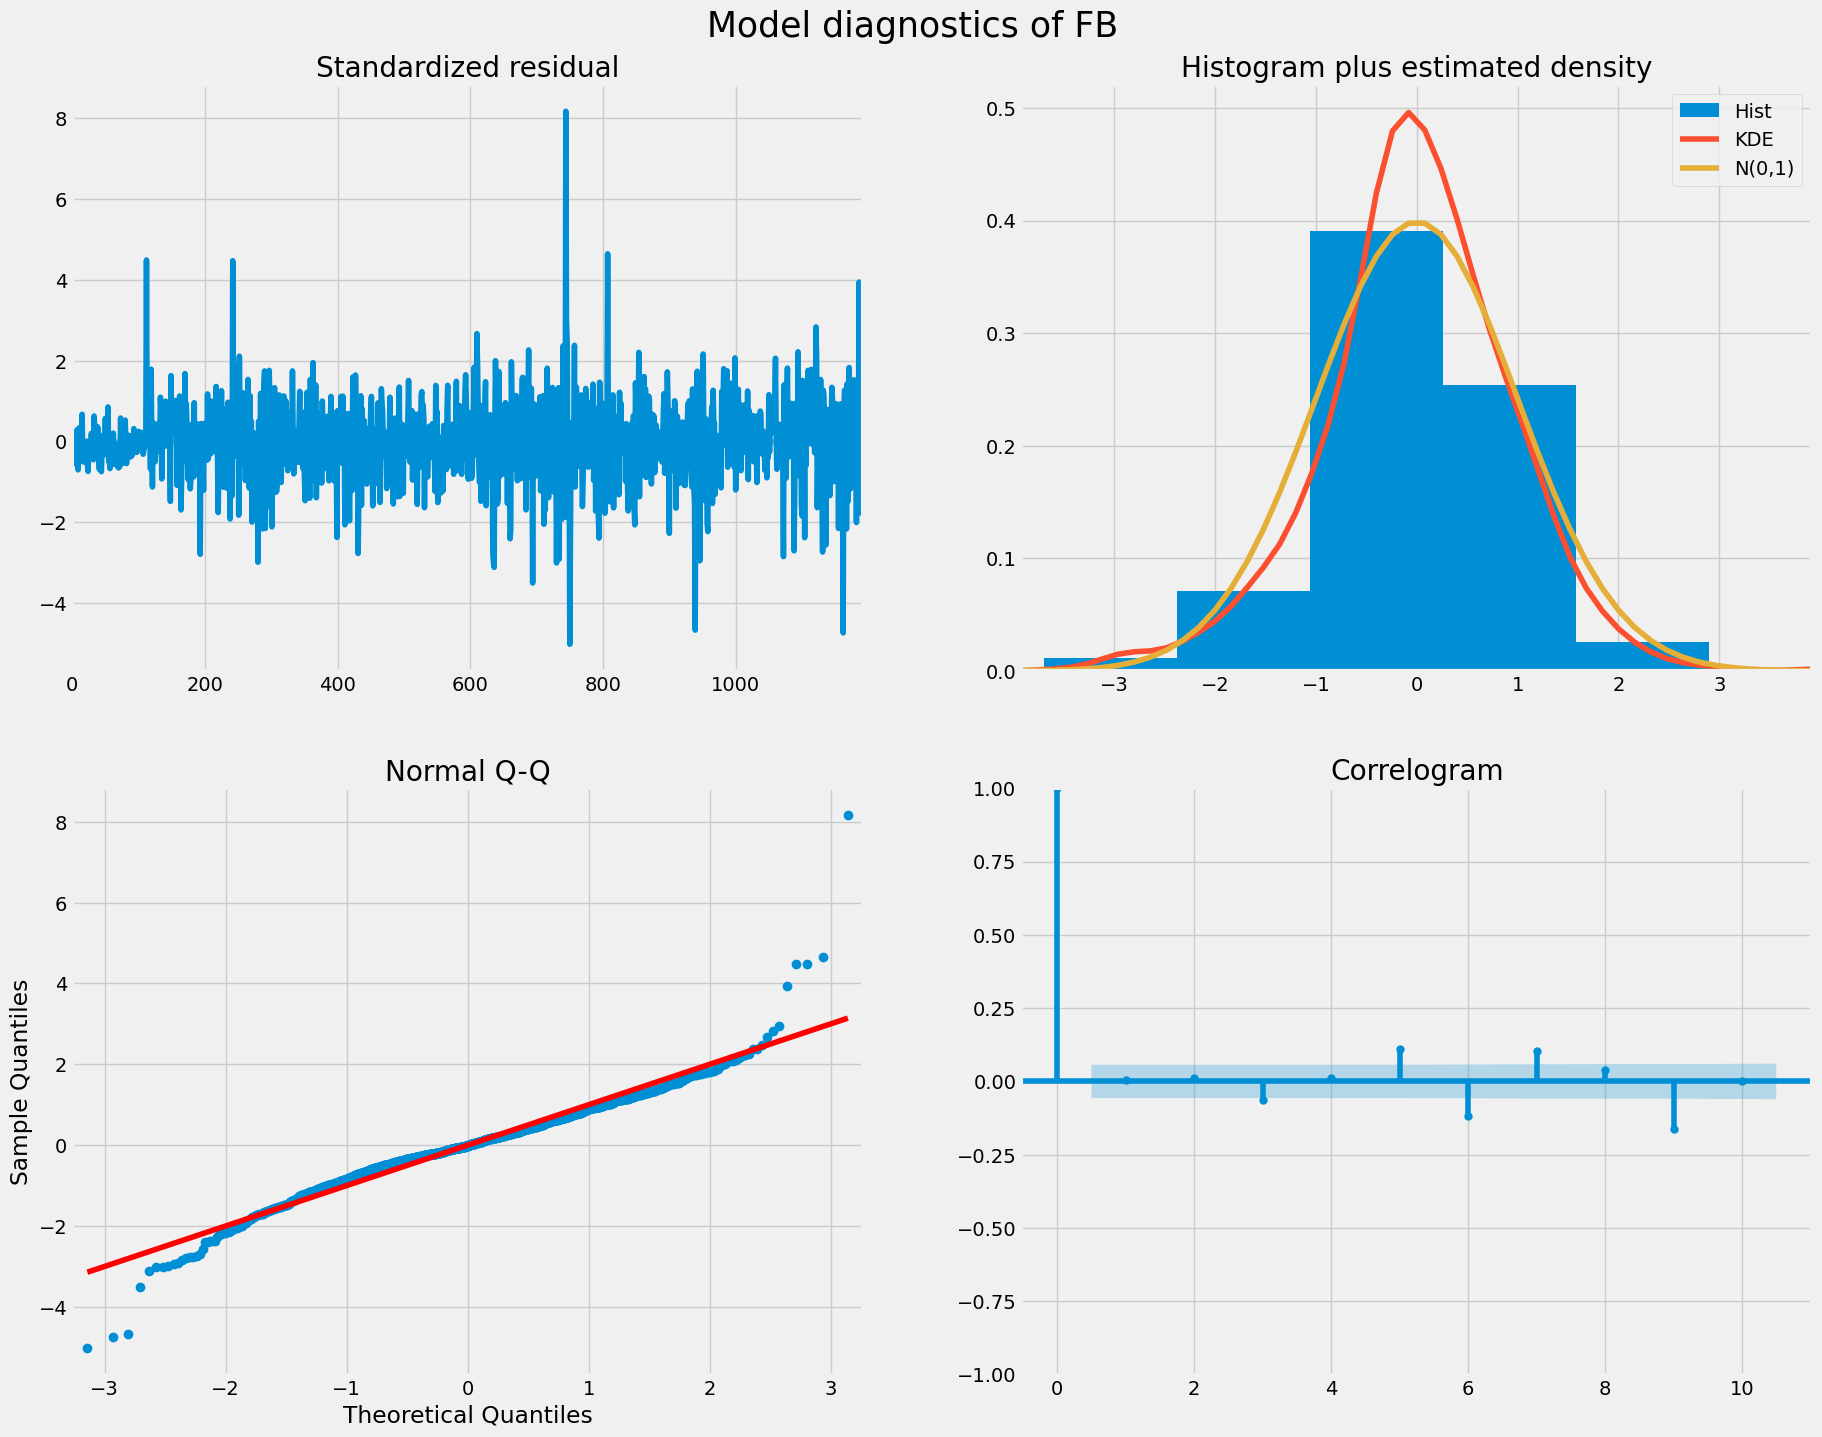

In [51]:
# let's plot forecasting models plots
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')    #Setting the sytle commonly used in five thirty eight sites
    #This method is specific to ARIMA models , generates a set of diagnostics plots for the model
    model.plot_diagnostics(figsize = (20, 15));    
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(model_apl, 'AAPL')
print("-------"*20)
display_model_plots(model_fb, 'FB')

Graph Interpretation:
1. Standardized Residual: This shows the errors(predicted value - actual value) of the models after standardizing them(transforming them to have a mean of 0 and a standard deviation of 1). If there is a lot of randomness in this scatter plot in the horizantal line then this means that the model captures the data's pattern well. Both of our graphs have a lot of randomness so we can assume that our model works well.(x-axis in this graph has the index of the data points in series)
2. Histogram plus estimated density plot: the plot displays the distribution of standardized residuals and if the histogram resembles a bell-shaped curve centered around zero. This suggests that the residuals follow a normal distribution. Which both of our graphs do.
3. Normal Q-Q: Normal Q-Q plot helps us to check if our data follows a normal distribution. If most of the points fall on a straight line, it suggests that our data is likely normally distributed. But if the points deviate from this line, it suggests that our data might be skewed, meaning it has more extreme values on one side than the other.(Y - axis is distribuion of standardized residuals and X-axis is theoritical normal distributtion).
4. Correlogram: It simply indicates auto-correlation of residuals. Ideally, it should be zero for all lags but if it isn' that means the model hasn't captured all trends.

In [52]:
# Confidence interval is a range of values where we are pretty sure the true value lies
def make_predictions_and_print_rmse(model, test_df, co_name):
    print(f"forecasting and RMSE of {co_name}")
    #n_periods means for how many days we will make the prediction if it is 1 we will only make it 1 day after training
    forecast, confidence_interval = model.predict(n_periods = len(test_df), return_conf_int = True)
    
    #Converting the forecast list into a series and then setting its index as the test_df's index
    forecast = pd.Series(forecast)
    forecast.index = test_df.index
    
    #Creating series of lower ranges and upper ranges of confidence intervals
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)
    
    #Calculating Root mean Square error
    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))
    
    print("RMSE is: ", rmse)
    final =  pd.DataFrame({'Forecasted Value': forecast, 'Actual Value': test_df, 'Lower Range': lower, 'Upper Range': upper})
    
    return final

forecast = make_predictions_and_print_rmse(model_apl, apl_test, 'APPLE')
print("----------------------------")
forecastf = make_predictions_and_print_rmse(model_fb, fb_test, 'FB')

print(forecastf)

forecasting and RMSE of APPLE
RMSE is:  7.30289859525892
----------------------------
forecasting and RMSE of FB
RMSE is:  4.205905964689313
        Forecasted Value  Actual Value  Lower Range  Upper Range
219805        178.433374        180.25   175.129295   181.737452
219806        177.835036        179.56   173.363847   182.306225
219807        181.121983        179.30   175.959288   186.284679
219808        179.636962        178.46   173.608124   185.665801
219809        179.292498        178.77   172.756070   185.828926
...                  ...           ...          ...          ...
219863        185.340034        193.09   167.760079   202.919989
219864        187.865498        190.28   170.213464   205.517533
219865        185.991651        181.26   168.131946   203.851355
219866        185.718511        185.31   167.730219   203.706803
219867        188.244032        180.18   170.185287   206.302778

[63 rows x 4 columns]


In [53]:
import pickle
# with open('model_apl.pkl', 'wb') as file:
#     pickle.dump(model_apl, file)
# with open('model_fb.pkl', 'wb') as file:
#     pickle.dump(model_fb, file)
    
# with open('apl_test.pkl', 'wb') as file:
#     pickle.dump(apl_test, file)

# with open('fb_test.pkl', 'wb') as file:
#     pickle.dump(fb_test, file)

#with open('apl_test.pkl', 'wb') as file:
    #pickle.dump(apl_test, file)

In [54]:
apl_test

2455    174.81
2456    176.24
2457    175.88
2458    174.67
2459    173.97
         ...  
2513    167.78
2514    160.50
2515    156.49
2516    163.03
2517    159.54
Name: y, Length: 63, dtype: float64